# **Import**

In [ ]:
%%capture
pip install phik

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import phik

from IPython.display import display, HTML
from scipy.stats import chi2_contingency
from matplotlib.colors import LinearSegmentedColormap
from phik import report

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

# **Functions**

## **Generating a Statistical Summary Table (DataFrame)**

**Description:** Creates a DataFrame containing the primary descriptive statistics for a feature. It is used for numerical distribution analysis, identifying outliers, and detecting missing values. Returns a standard DataFrame with all key metrics.

In [ ]:
def get_numerical_summary(df: pd.DataFrame, feature_name: str, unit: str) -> pd.DataFrame:
    if feature_name not in df.columns:
        return pd.DataFrame({"Error": [f"Feature {feature_name} not found"]})

    series = df[feature_name].dropna()

    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    stats_data = {
        "Metric": [
            "Total Count", "Missing Values", "Missing Percentage (%)",
            "Mean", "Median", "Standard Deviation",
            "Variance", "Minimum", "Maximum", "Skewness",
            "Kurtosis", "Outlier Count", "Lower Bound", "Upper Bound"
        ],
        f"Value ({unit})": [
            len(df), df[feature_name].isna().sum(), (df[feature_name].isna().sum() / len(df)) * 100,
            series.mean(), series.median(), series.std(), series.var(),
            series.min(), series.max(), series.skew(), series.kurt(),
            len(series[(series < low) | (series > high)]), low, high
        ]
    }

    res_df = pd.DataFrame(stats_data)

    res_df[f"Value ({unit})"] = res_df[f"Value ({unit})"].apply(
        lambda x: round(x, 1) if isinstance(x, (int, float)) else x
    )
    return res_df

## **Distribution Analysis Plotting Function (Seaborn)**

**Description:** This function generates a combined plot featuring a histogram and a Kernel Density Estimate (KDE) curve to analyze the distribution shape of a numerical feature.

In [ ]:
def plot_numerical_distribution(df: pd.DataFrame, feature_name: str, unit: str):
    if feature_name not in df.columns:
        print(f"Error: Feature {feature_name} not found")
        return

    sns.set_style("whitegrid", {'axes.grid': False})
    plt.rcParams['font.family'] = 'sans-serif'
    plt.figure(figsize=(10, 5))

    sns.histplot(
        df[feature_name],
        bins=40,
        kde=True,
        color='#4682B4',
        edgecolor='white',
        alpha=0.6,
        line_kws={'linewidth': 2}
    )

    mean_val = df[feature_name].mean()
    median_val = df[feature_name].median()

    plt.axvline(mean_val, color='#FF6347', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='#2ECC71', linestyle='-', linewidth=2,
                label=f'Median: {median_val:.1f}')

    plt.title(f'Distribution: {feature_name}', fontsize=14, pad=20)
    plt.xlabel(f'{feature_name} ({unit})', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)

    plt.legend(frameon=True, loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

## **Relationship Analysis Between Numerical Features and Target Variable**

**Description:**

* **Violin Visualization (Violin Plot):** This function creates violin plots that allow for a simultaneous assessment of distribution density and quartiles of a numerical feature for each weight category, revealing hidden patterns in the data.
* **Statistical Summary:** The `get_feature_target_pivot` tool generates a detailed table of aggregated metrics (mean, median, standard deviation), enabling the confirmation of visual trends with precise figures.
* **Comparative Analysis:** Combining graphical and tabular methods provides a comprehensive evaluation of how physical parameters or dietary habits (e.g., age or water consumption) change as one moves from underweight status to various stages of obesity.

In [ ]:
def plot_feature_by_target_dark(df: pd.DataFrame, feature_name: str, unit: str):
    """
    UNIVERSAL VIOLIN PLOT
    """
    if feature_name not in df.columns:
        return

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid", {'axes.grid': False})
    plt.rcParams['font.family'] = 'sans-serif'

    sns.violinplot(
        data=df,
        x='NObeyesdad',
        y=feature_name,
        color='#003366',
        inner="quartile",
        linewidth=1.5,
        edgecolor='white',
        alpha=0.8,
        cut=0
    )

    plt.title(f'Distribution Analysis: {feature_name}', fontsize=14, pad=20)
    plt.xlabel('Weight Category', fontsize=11)
    plt.ylabel(f'{feature_name} ({unit})', fontsize=11)
    plt.xticks(rotation=45, ha='right')

    plt.grid(axis='y', linestyle=':', alpha=0.3)
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

def get_feature_target_pivot(df: pd.DataFrame, feature_name: str):
    """Pivot table by weight categories."""
    pivot = df.groupby('NObeyesdad')[feature_name].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(1)
    pivot.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max']
    return pivot.sort_values(by='Median')

## **Categorical Feature Distribution Analysis**

**Description:**

* Generates interactive HTML tables grouped by feature. It highlights the most frequent values (**Mode**) and calculates **Imbalance** (the ratio of the most frequent class to the least frequent one).
* Plots multiple bar charts in a grid, automatically adjusting their size. This allows for a side-by-side comparison of different feature distributions on a single screen.
* Displays precise percentage values above each bar and rotates long label names by 45° to prevent overlapping.
* Standardizes all plots to a "clean" appearance without redundant frames or grids, removing black outlines to meet modern data visualization standards.

In [ ]:
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['font.family'] = 'sans-serif'

custom_style = """
<style>
    .analysis-container { width: 95%; margin: 20px auto; font-family: Arial, sans-serif; }
    .ordinal-table { width: 100%; border-collapse: collapse; margin: 10px 0; font-size: 14px; }
    .ordinal-table th { background: #495057; color: white; padding: 12px 8px; text-align: center; font-weight: 800; }
    .ordinal-table td { padding: 10px 8px; border: 1px solid #dee2e6; text-align: center; font-weight: 600; }
    .mode-highlight { background-color: #e9ecef !important; font-weight: 700; }
</style>
"""

def generate_styled_table(df, title):
    html = f'<div class="analysis-container"><h3 style="background:#f8f9fa; padding:10px; border:2px solid #333; border-radius:8px;">{title}</h3>'
    html += '<table class="ordinal-table"><thead><tr>'
    for col in ['Feature', 'Class', 'Count', 'Percentage (%)', 'Mode', 'Imbalance']:
        html += f'<th>{col}</th>'
    html += '</tr></thead><tbody>'

    for feat in df['Feature'].unique():
        sub = df[df['Feature'] == feat]
        for i, (_, row) in enumerate(sub.iterrows()):
            row_style = 'class="mode-highlight"' if i == 0 else ''
            html += f'<tr {row_style}>'
            if i == 0:
                html += f'<td rowspan="{len(sub)}" style="text-align:left; font-weight:700;">{feat}</td>'
            html += f'<td style="text-align:left;">{row["Class"]}</td>'
            html += f'<td>{row["Count"]:,}</td><td>{row["Percentage (%)"]}%</td>'
            if i == 0:
                html += f'<td rowspan="{len(sub)}">{row["Mode"]}</td>'
                html += f'<td rowspan="{len(sub)}">{row["Imbalance"]}</td>'
            html += '</tr>'
    return html + "</tbody></table></div>"

def plot_categorical_grid(df, features, translations, colors='#4682B4'):
    n_feat = len(features)
    fig, axes = plt.subplots(1, n_feat, figsize=(n_feat * 4, 5))
    if n_feat == 1: axes = [axes]

    for ax, feat in zip(axes, features):
        data = df[feat].value_counts().sort_index()

        sns.barplot(x=data.index, y=data.values, ax=ax, color=colors, alpha=0.7, edgecolor=None)

        total = len(df)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = f'{100 * height / total:.1f}%'
                ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', xytext=(0, 5),
                            textcoords='offset points', fontsize=9)

        ax.set_title(f'{translations.get(feat, feat)}', fontsize=12, pad=15)
        ax.set_ylabel('Frequency')

        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()

## **Categorical Feature Distribution by Target Variable (Visualizations)**

**Description:** This function generates grouped bar charts to visualize the relationship between categorical features and the target variable. It displays weight categories on the X-axis while using colors (*hue*) to represent the distribution of feature responses within each category, supplemented by percentage annotations for precise comparison.


In [ ]:
def plot_target_by_categorical(df, features, target_col='NObeyesdad', translations=None):
    """
    Plots charts where the X-axis represents obesity levels,
    and colors (hue) show the distribution of responses within each level.
    """
    translations = translations or {}

    for feat in features:
        plt.figure(figsize=(12, 6))

        ax = sns.countplot(
            data=df,
            x=target_col,
            hue=feat,
            palette='Blues_d',
            alpha=0.7,
            edgecolor=None
        )

        total = len(df)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = f'{100 * height / total:.1f}%'
                ax.annotate(percentage,
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 5),
                            textcoords='offset points',
                            fontsize=8)

        feat_name = translations.get(feat, feat)
        plt.title(f'Distribution of "{feat_name}" across Obesity Levels', fontsize=13, pad=20)
        plt.xlabel('Obesity Level (NObeyesdad)', fontsize=11)
        plt.ylabel('Frequency')

        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        plt.legend(title=feat_name, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

        sns.despine(left=True)
        plt.tight_layout()
        plt.show()

## **Encoding Report**

**Description:**
These functions provide a visual representation of the feature encoding process by converting the preprocessor's internal dictionaries into structured HTML cards. The code implements custom color coding for different transformation types (Ordinal, One-Hot) and automatically documents the application of technical parameters, such as `drop_first=True` for nominal features.

In [ ]:
class DataPreprocessor:
    def __init__(self, drop_columns=None):
        self.drop_columns = drop_columns if drop_columns else []
        self.mappings = {}
        self.target_map = {}
        self.ohe_columns = []

    def preprocess(self, df: pd.DataFrame, fit: bool = True) -> pd.DataFrame:
        df_encoded = df.copy()

        df_encoded = df_encoded.drop(columns=self.drop_columns, errors='ignore')

        binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
        binary_map = {'no': 0, 'yes': 1}

        if fit:
            self.mappings['binary'] = {col: binary_map for col in binary_cols if col in df_encoded.columns}

        for col in binary_cols:
            if col in df_encoded.columns:
                mapping = binary_map if fit else self.mappings.get('binary', {}).get(col, binary_map)
                df_encoded[col] = df_encoded[col].map(mapping)

        caec_order = ['no', 'Sometimes', 'Frequently', 'Always']
        calc_order = ['no', 'Sometimes', 'Frequently', 'Always']

        if fit:
            caec_map = {val: idx for idx, val in enumerate(caec_order)}
            calc_map = {val: idx for idx, val in enumerate(calc_order)}
            self.mappings['ordinal'] = {'CAEC': caec_map, 'CALC': calc_map}
        else:
            caec_map = self.mappings.get('ordinal', {}).get('CAEC', {})
            calc_map = self.mappings.get('ordinal', {}).get('CALC', {})

        if 'CAEC' in df_encoded.columns:
            df_encoded['CAEC'] = df_encoded['CAEC'].map(caec_map)
        if 'CALC' in df_encoded.columns:
            df_encoded['CALC'] = df_encoded['CALC'].map(calc_map)

        if 'NObeyesdad' in df_encoded.columns:
            obesity_order = [
                'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
                'Obesity_Type_III'
            ]
            if fit:
                obesity_map = {val: idx for idx, val in enumerate(obesity_order)}
                self.target_map = obesity_map
            else:
                obesity_map = self.target_map
            df_encoded['NObeyesdad'] = df_encoded['NObeyesdad'].map(obesity_map)

        ohe_cols = ['Gender', 'MTRANS']
        if fit:
            for col in ohe_cols:
                if col in df_encoded.columns:
                    unique_vals = sorted(df_encoded[col].unique())
                    actual_dummies = unique_vals[1:]
                    self.ohe_columns.extend([f"{col}_{val}" for val in actual_dummies])

            df_encoded, new_cols_map = self._get_dummies_and_track(df_encoded, columns=ohe_cols, drop_first=True)
            self.mappings['one_hot_cols'] = new_cols_map
        else:
            df_encoded = self._apply_one_hot(df_encoded, ohe_cols)

        for col in df_encoded.columns:
            if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
                try:
                    df_encoded[col] = pd.to_numeric(df_encoded[col])
                except:
                    pass
        return df_encoded

    def _get_dummies_and_track(self, df, columns, drop_first=True):
        new_cols = {}
        for col in columns:
            if col in df.columns:
                dummies = pd.get_dummies(df[col], prefix=col, drop_first=drop_first)
                df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
                new_cols[col] = dummies.columns.tolist()
        return df, new_cols

    def _apply_one_hot(self, df, columns):
        for col in columns:
            if col in df.columns:
                dummies = pd.get_dummies(df[col], prefix=col)
                expected_cols = [c for c in self.ohe_columns if c.startswith(f"{col}_")]
                for expected in expected_cols:
                    if expected not in dummies.columns:
                        dummies[expected] = 0
                dummies = dummies[expected_cols]
                df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
        return df

    def generate_mapping_report(self) -> pd.DataFrame:
        report = []
        for col, mapping in self.mappings.get('binary', {}).items():
            for key, val in mapping.items():
                report.append({'Feature': col, 'Original Value': key, 'Code': val, 'Method': 'Binary'})
        for col, mapping in self.mappings.get('ordinal', {}).items():
            for key, val in mapping.items():
                report.append({'Feature': col, 'Original Value': key, 'Code': val, 'Method': 'Ordinal'})
        for key, val in self.target_map.items():
            report.append({'Feature': 'NObeyesdad (Target)', 'Original Value': key, 'Code': val, 'Method': 'Ordinal (Target)'})
        for original_col, new_cols in self.mappings.get('one_hot_cols', {}).items():
            for nc in new_cols:
                report.append({'Feature': original_col, 'Original Value': nc.replace(f"{original_col}_", ""), 'Code': 1, 'Method': f'OHE (Col: {nc})'})

        return pd.DataFrame(report)

In [ ]:
def display_horizontal_reports(mapping_dict, title, bg_color='#f0f4f7', text_color='#003366'):
    """
    Creates horizontal layout for a dictionary of mappings.
    """
    html_output = f"<h3 style='color:#003366; font-family:sans-serif; margin-bottom:15px;'>{title}</h3>"
    html_output += "<div style='display: flex; flex-wrap: wrap; gap: 40px; align-items: flex-start;'>"

    for col, mapping in mapping_dict.items():
        df_rep = pd.DataFrame(list(mapping.items()), columns=['Original Value', 'Code'])

        table_html = df_rep.style.hide(axis='index')\
            .set_table_attributes(f"style='border-collapse: collapse; min-width: 150px; font-family: sans-serif;'")\
            .set_properties(**{
                'background-color': bg_color,
                'color': text_color,
                'border': '2px solid white',
                'padding': '8px',
                'text-align': 'center'
            })\
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', text_color), ('color', 'white'), ('font-weight', 'bold'), ('padding', '10px')]}
            ])\
            .to_html()

        html_output += f"""
        <div style='border: 1px solid #d1d8e0; border-radius: 8px; padding: 15px; background-color: #ffffff; box-shadow: 2px 2px 5px rgba(0,0,0,0.05);'>
            <div style='font-weight: bold; color: {text_color}; margin-bottom: 10px; border-bottom: 2px solid {text_color}; padding-bottom: 5px;'>
                {col}
            </div>
            {table_html}
        </div>
        """

    html_output += "</div>"
    display(HTML(html_output))

def display_ohe_reports(preprocessor):
    """Specific layout for One-Hot Encoding due to different data structure."""
    ohe_mappings = preprocessor.mappings.get('one_hot_cols', {})

    html_output = "<h3 style='color:#664d00; font-family:sans-serif; margin-bottom:15px;'>ONE-HOT ENCODING (NOMINAL FEATURES)</h3>"
    html_output += "<div style='display: flex; flex-wrap: wrap; gap: 40px; align-items: flex-start;'>"

    for original_col, new_cols in ohe_mappings.items():
        ohe_data = []
        for nc in new_cols:
            val = nc.replace(f"{original_col}_", "")
            ohe_data.append({'Original Value': val, 'New Column': nc})

        df_rep = pd.DataFrame(ohe_data)

        table_html = df_rep.style.hide(axis='index')\
            .set_table_attributes("style='border-collapse: collapse; min-width: 250px; font-family: sans-serif;'")\
            .set_properties(**{
                'background-color': '#fdf9ee',
                'color': '#664d00',
                'border': '2px solid white',
                'padding': '8px'
            })\
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#664d00'), ('color', 'white'), ('font-weight', 'bold'), ('padding', '10px')]}
            ])\
            .to_html()

        html_output += f"""
        <div style='border: 1px solid #e3d9b1; border-radius: 8px; padding: 15px; background-color: #ffffff; box-shadow: 2px 2px 5px rgba(0,0,0,0.05);'>
            <div style='font-weight: bold; color: #664d00; margin-bottom: 10px; border-bottom: 2px solid #664d00; padding-bottom: 5px;'>
                {original_col} (Dummies)
            </div>
            <p style='font-size: 12px; color: #888;'>Mode: drop_first=True</p>
            {table_html}
        </div>
        """

    html_output += "</div>"
    display(HTML(html_output))

# **Obesity Information**

Obesity is defined as a multifactorial chronic disease characterized by the pathological proliferation of adipose tissue. This condition is associated with a significantly increased risk of metabolic, cardiovascular, and oncological pathologies.

---

## 1. Anthropometric Markers and Risk Stratification

The **Body Mass Index (BMI)** serves as the central screening tool in epidemiological studies. The mathematical model for BMI is defined as the ratio of body mass to the square of height:

### Health Status Category Classification

The dataset used in this study presents an expanded hierarchy of classes based on WHO standards, offering a deeper discretization of obesity levels:

| WHO Category | BMI Range () | Dataset Equivalent |
| --- | --- | --- |
| **Underweight** | < 18.5 | `Insufficient_Weight` |
| **Normal Weight** | 18.5 – 24.9 | `Normal_Weight` |
| **Pre-obesity** | 25.0 – 29.9 | `Overweight_Level_I / II` |
| **Obesity Class I** | 30.0 – 34.9 | `Obesity_Type_I` |
| **Obesity Class II** | 35.0 – 39.9 | `Obesity_Type_II` |
| **Obesity Class III** | ≥ 40.0 | `Obesity_Type_III` |

> [!NOTE]
> The detailing of `Overweight` and `Obesity` levels allows algorithms to more accurately identify transitional states and differentiate risk groups.

### Fat Deposition Topography

The predictive value of BMI is supplemented by an analysis of adipocyte localization, which is critical for assessing cardiometabolic load:

* **Abdominal Type ("Android"):** Characterized by visceral fat deposition. It possesses high endocrine activity, often triggering insulin resistance.
* **Gynoid Type ("Peripheral"):** Predominant deposition in the hip and gluteal segment, more commonly observed in women.

---

## 2. Etiological Factors and Data Determinants

The development of obesity is viewed as the result of synergy between genetic predisposition and environmental triggers.

### 2.1. Behavioral Patterns

This group of factors is most widely represented in the dataset, allowing for the modeling of lifestyle impacts:

* **Nutritional Profile:** Direct influence on energy balance is exerted by the frequency of high-calorie food consumption (`FAVC`), the proportion of vegetables in the diet (`FCVC`), and nutritional load patterns (`NCP`, `CAEC`).
* **Hydration Regime (`CH2O`):** Adequate hydration is considered a factor in modulating satiety and metabolic reaction rates.
* **Physical Activity and Sedentary Behavior:** The balance between physical activity (`FAF`) and screen time (`TUE`) determines total energy expenditure.

### 2.2. Biological and Hereditary Determinants

* **Genetic Predictor (`family_history_with_overweight`):** A powerful independent feature aggregating hereditary metabolic traits and family eating behavior patterns.
* **Gender Dimorphism (`Gender`):** Affects the basal metabolic rate and the ratio of muscle to adipose tissue.

---

## 3. Analytical Structure of Features (Feature Engineering)

To build high-precision models, variables have been classified according to their functional role in pathogenesis:

| Feature Group | Variables | Role in Modeling |
| --- | --- | --- |
| **Biological** | `Age`, `Gender`, `Height`, `Weight` | Establishing the baseline physiological profile. |
| **Genetic** | `family_history_with_overweight` | Accounting for long-term predisposition. |
| **Nutritional** | `FAVC`, `FCVC`, `NCP`, `CAEC`, `CH2O`, `CALC` | Assessing dietary structure and habits. |
| **Activity** | `FAF`, `TUE`, `MTRANS` | Evaluating sedentary levels and lifestyle. |

### Interaction Effects

1. **Interpretation of `Gender`:** With identical BMI indicators, the risk of complications in men may be higher due to a tendency toward visceral obesity.
2. **Dynamics of `Age`:** As age increases, a physiological slowing of metabolic processes is observed. In modeling, this requires accounting for non-linear dependencies, as the significance of physical activity (`FAF`) increases when transitioning into older age groups.

# **Data Loading**

In [ ]:
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')

In [ ]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [ ]:
df.shape

(20758, 18)

In [ ]:
df = df.drop(columns=['id'])
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


# **Numerical Feature Analysis of the Dataset**

## **1. Age Feature Analysis**

In [ ]:
print("STATISTICAL SUMMARY: AGE")
age_stats = get_numerical_summary(df, 'Age', 'years')
display(age_stats)

STATISTICAL SUMMARY: AGE


,Metric,Value (years)
0,Total Count,20758.0
1,Missing Values,0.0
2,Missing Percentage (%),0.0
3,Mean,23.8
4,Median,22.8
5,Standard Deviation,5.7
6,Variance,32.4
7,Minimum,14.0
8,Maximum,61.0
9,Skewness,1.6


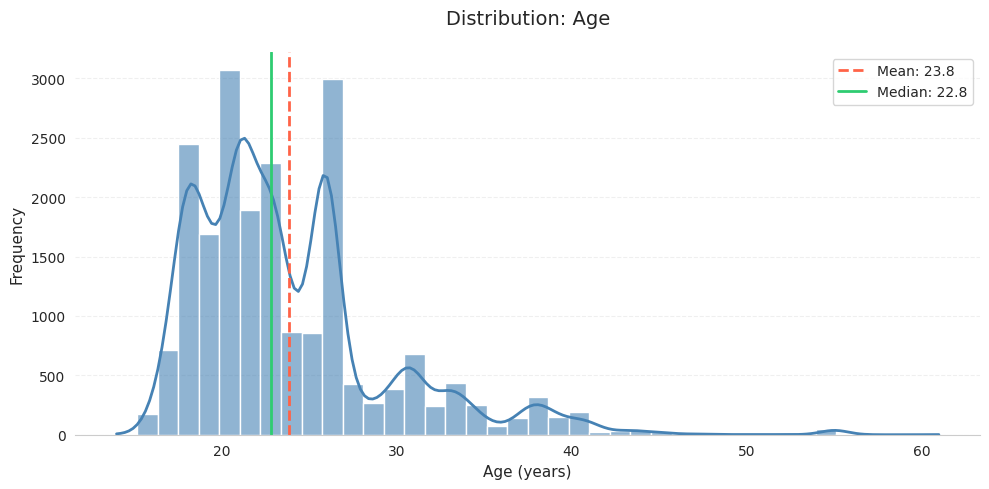

In [ ]:
plot_numerical_distribution(df, 'Age', 'years')


**Analysis of the "Age" Feature Distribution**

* **Central Tendencies:** The mean age of the participants is **23.8 years**, while the median is **22.8 years**. The minor difference between these values indicates that the bulk of the data is concentrated within the younger age group.
* **Variability and Range:** The data covers a range from **14 to 61 years**. A standard deviation of **5.7 years** suggests a moderate spread of values relative to the center.
* **Distribution Shape:** The skewness coefficient (**Skewness = 1.6**) confirms a right-skewed distribution—younger individuals predominate in the sample, with the "tail" of the distribution extending toward older ages. The kurtosis (**Kurtosis = 3.7**) indicates a leptokurtic distribution (a high concentration of data around the median).
* **Outliers:** There are **1,074 observations** exceeding the upper bound of **35 years**. These values are not data entry errors; rather, they represent an older age group that is statistically specific relative to the generally "young" sample.
* **Data Quality:** There are no missing values; the data is valid and ready for further analysis.

In [ ]:
print("AGE ANALYSIS BY WEIGHT CATEGORIES")
display(get_feature_target_pivot(df, 'Age'))

AGE ANALYSIS BY WEIGHT CATEGORIES


,Count,Mean,Median,Std,Min,Max
NObeyesdad,,,,,,
Insufficient_Weight,2523,19.3,19.0,2.2,16.0,43.2
Normal_Weight,3082,20.8,21.0,3.4,14.0,51.0
Overweight_Level_I,2427,23.0,21.0,5.9,15.0,61.0
Obesity_Type_I,2910,25.0,22.9,7.2,14.0,55.0
Overweight_Level_II,2522,26.0,23.0,7.8,16.8,56.0
Obesity_Type_III,4046,24.1,26.0,2.6,18.0,30.6
Obesity_Type_II,3248,27.7,26.7,4.3,17.0,53.8


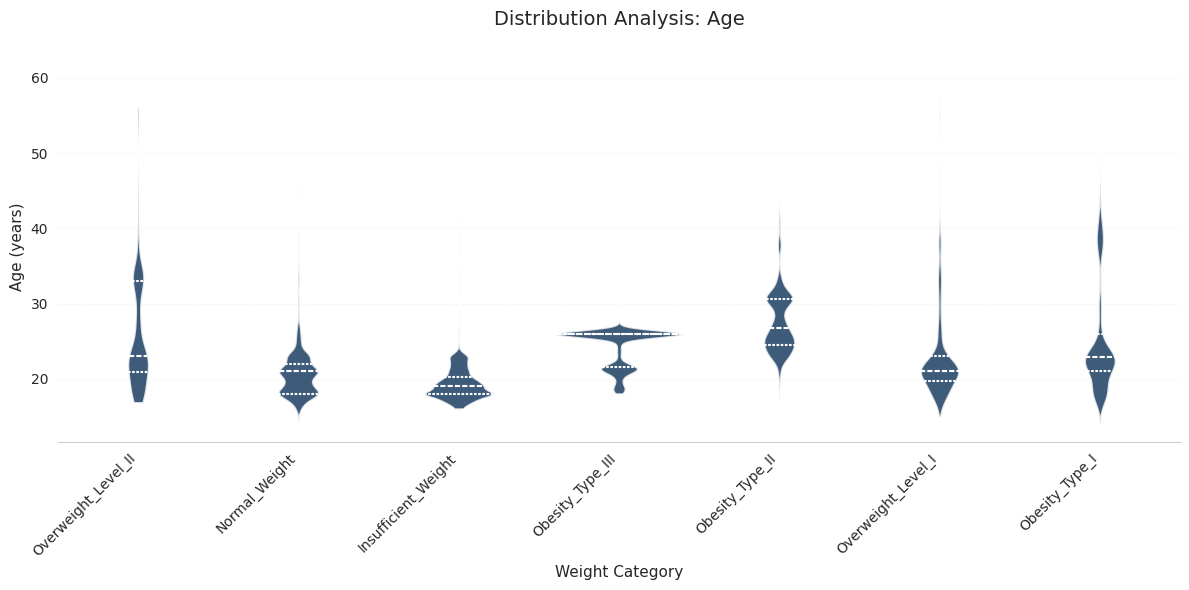

In [ ]:
plot_feature_by_target_dark(df, 'Age', 'years')

 **Analysis of Age Distribution Across Weight Categories**

* **Age Gradient:** There is a distinct trend of increasing age when moving from underweight status to more severe stages of obesity. The "youngest" group is `Insufficient_Weight` (median **19 years**), while the oldest groups are `Obesity_Type_II` and `Obesity_Type_III` (median **26–26.7 years**).
* **Data Concentration:** The `Obesity_Type_III` group is the most numerous (**4,046 people**) and the most age-homogeneous (lowest spread with `Std = 2.6` and a narrow range from **18 to 30.6 years**). This indicates that this degree of obesity in the sample is characteristic of a specific young age group.
* **Variability (Spread):** The greatest age variability is observed in the `Overweight_Level_II` and `Obesity_Type_I` categories (`Std` **7.2–7.8**). This suggests that excess weight at these levels occurs across the widest age range—from teenagers to individuals over 55 years old.
* **Anomalies (Extremes):** The `Overweight_Level_I` group contains the oldest observation in the dataset (**61 years**), whereas normal weight and underweight status are most frequently found in individuals under 21 years of age.

## **2. Weight Feature Analysis**

In [ ]:
print("STATISTICAL SUMMARY: WEIGHT")
weight_stats = get_numerical_summary(df, 'Weight', 'kg')
display(weight_stats)

STATISTICAL SUMMARY: WEIGHT


,Metric,Value (kg)
0,Total Count,20758.0
1,Missing Values,0.0
2,Missing Percentage (%),0.0
3,Mean,87.9
4,Median,84.1
5,Standard Deviation,26.4
6,Variance,695.9
7,Minimum,39.0
8,Maximum,165.1
9,Skewness,0.1


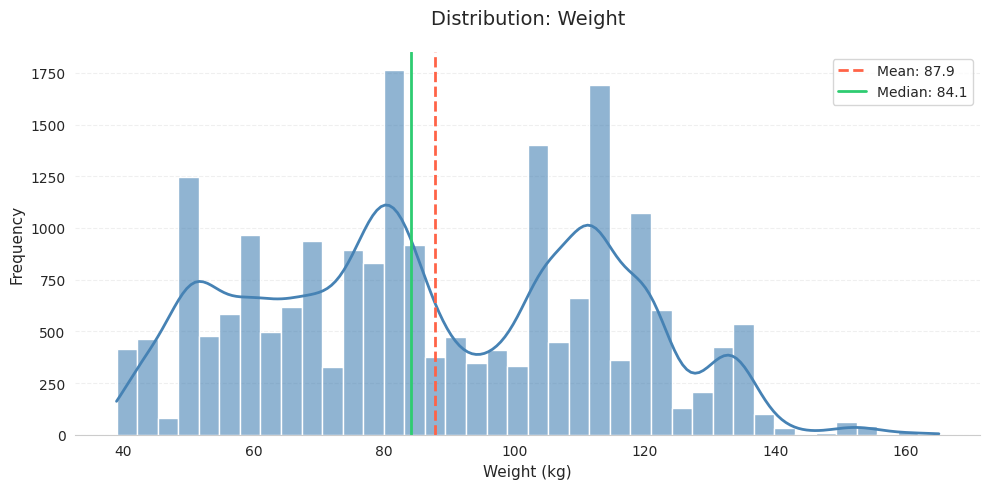

In [ ]:
plot_numerical_distribution(df, 'Weight', 'kg')

**Analysis of the "Weight" Feature Distribution**

* **Central Tendencies:** The mean weight of participants is **87.9 kg**, while the median is lower at **84.1 kg**. This indicates the presence of a group of respondents with very high weight values that pull the mean upward.
* **Variability:** There is a significant spread in the data: the standard deviation is **26.4 kg**, and the difference between the minimum (**39 kg**) and maximum (**165.1 kg**) values reaches **126 kg**. This confirms that the sample includes all body types—from severe underweight to morbid obesity.
* **Distribution Shape:**
* **Skewness (0.1):** The distribution is nearly symmetrical, which is somewhat atypical for biological data and often suggests a synthetic dataset or a very balanced sample.
* **Kurtosis (-1.0):** The negative value indicates a "platykurtic" (flat-topped) distribution. This means the data does not concentrate around a single peak but is distributed more evenly across different weight categories.
* **Outliers:** There are **no statistical outliers** (0.0) based on the Interquartile Range (IQR) method. All values, including the extreme 165 kg, fall within the calculated boundaries (the upper bound is 180 kg) and are considered valid for this study.
* **Data Quality:** The data is complete (0% missing values), and no anomalies requiring removal were detected.

In [ ]:
print("WEIGHT ANALYSIS BY WEIGHT CATEGORIES")
display(get_feature_target_pivot(df, 'Weight'))

WEIGHT ANALYSIS BY WEIGHT CATEGORIES


,Count,Mean,Median,Std,Min,Max
NObeyesdad,,,,,,
Insufficient_Weight,2523,49.9,50.0,5.7,39.0,113.7
Normal_Weight,3082,61.5,60.0,8.5,41.9,90.0
Overweight_Level_I,2427,74.2,75.0,8.0,42.0,96.7
Overweight_Level_II,2522,82.1,81.6,7.4,55.0,115.0
Obesity_Type_I,2910,92.4,90.1,11.4,40.2,155.9
Obesity_Type_III,4046,117.7,111.9,13.3,42.0,165.1
Obesity_Type_II,3248,116.0,118.3,7.8,76.2,137.8


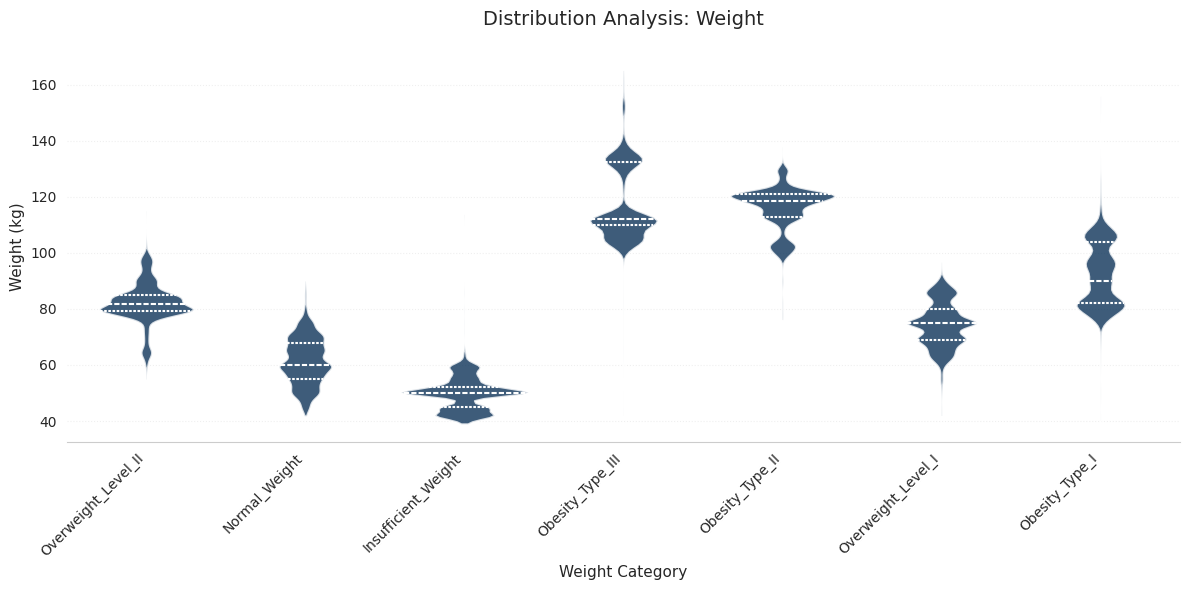

In [ ]:
plot_feature_by_target_dark(df, 'Weight', 'kg')

**Analysis of Weight Distribution Within Obesity Categories**

* **Linear Growth and Hierarchy:** There is a clear and consistent increase in median weight as we move from one category to the next: from a minimum of **50 kg** (`Insufficient_Weight`) to a peak of **118.3 kg** (`Obesity_Type_II`). This confirms that weight is a defining factor in the classification of this dataset.
* **Extreme Value Groups:** The `Obesity_Type_II` and `Obesity_Type_III` categories show the highest average weight values (**~116–117 kg**). Furthermore, the absolute maximum weight of **165.1 kg** is recorded within the `Obesity_Type_III` group.
* **Variability and "Blurred" Boundaries:** The highest dispersion (`Std = 13.3`) is observed in the `Obesity_Type_III` group, indicating a significant weight range within this category. It is also worth noting abnormally low minimum values in some severe categories (e.g., **40.2 kg** in `Obesity_Type_I` and **42.0 kg** in `Obesity_Type_III`), which highlights how height influences the Body Mass Index (BMI) calculation.
* **Category Overlap:** Significant overlap in ranges (Min/Max) between `Overweight_Level_II` and `Obesity_Type_I` suggests that individuals with the same weight may be classified into different categories depending on their height and other physiological parameters.

## **3. Height Feature Analysis**

In [ ]:
print("STATISTICAL SUMMARY: HEIGHT")
height_stats = get_numerical_summary(df, 'Height', 'm')
display(height_stats)

STATISTICAL SUMMARY: HEIGHT


,Metric,Value (m)
0,Total Count,20758.0
1,Missing Values,0.0
2,Missing Percentage (%),0.0
3,Mean,1.7
4,Median,1.7
5,Standard Deviation,0.1
6,Variance,0.0
7,Minimum,1.4
8,Maximum,2.0
9,Skewness,0.0


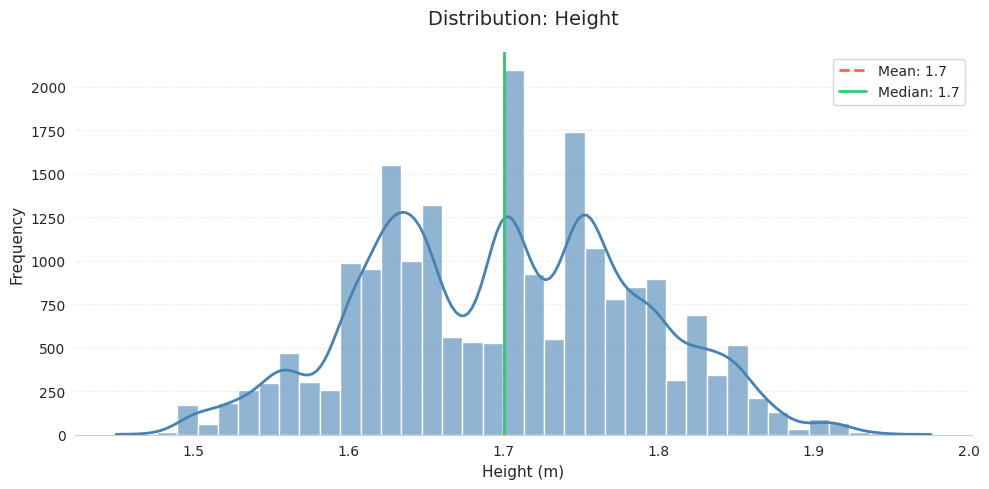

In [ ]:
plot_numerical_distribution(df, 'Height', 'm')

**Analysis of the "Height" Feature Distribution**

* **Perfect Symmetry:** The mean (**1.70 m**) and the median (**1.70 m**) are identical, and the skewness coefficient is virtually zero (**Skewness = 0.0**). This indicates an ideally symmetrical, classic normal distribution of the feature within the sample.
* **Anthropometric Boundaries:** Respondent height varies within a natural range from **1.45 m** to **1.98 m**. The standard deviation (**0.09 m**) shows that the majority of individuals in the sample fall between 1.61 m and 1.79 m.
* **Distribution Shape (Kurtosis = -0.6):** The negative kurtosis suggests that the distribution is slightly "flatter" than a standard normal distribution. This means the data isn't overly concentrated solely on average heights, indicating a sufficiently diverse sample.
* **Absence of Anomalies:** Only **4 outliers** were identified, which are actually located right on the calculated boundaries (1.45 m and 1.98 m). These are realistic height values and do not constitute measurement errors.
* **Data Quality:** The feature has no missing values and serves as a high-quality foundation for calculating BMI (Body Mass Index).

In [ ]:
print("HEIGHT ANALYSIS BY WEIGHT CATEGORIES")
display(get_feature_target_pivot(df, 'Height'))

HEIGHT ANALYSIS BY WEIGHT CATEGORIES


,Count,Mean,Median,Std,Min,Max
NObeyesdad,,,,,,
Obesity_Type_III,4046,1.7,1.6,0.1,1.5,1.9
Insufficient_Weight,2523,1.7,1.7,0.1,1.5,2.0
Obesity_Type_I,2910,1.7,1.7,0.1,1.5,2.0
Normal_Weight,3082,1.7,1.7,0.1,1.4,1.9
Overweight_Level_II,2522,1.7,1.7,0.1,1.5,1.9
Overweight_Level_I,2427,1.7,1.7,0.1,1.4,1.9
Obesity_Type_II,3248,1.8,1.8,0.1,1.5,2.0


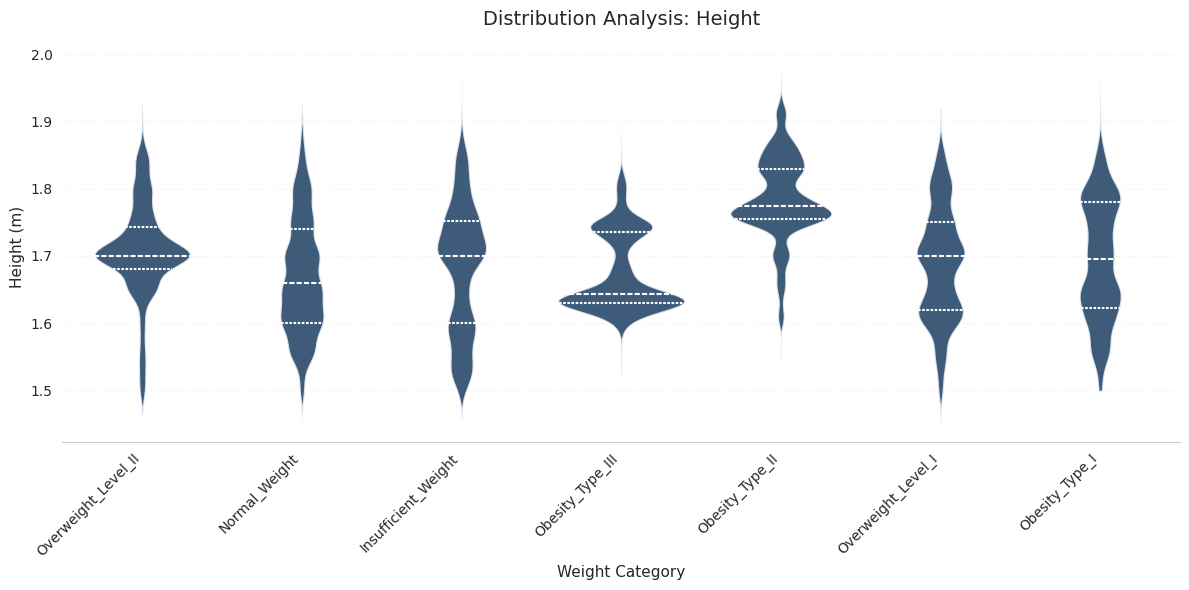

In [ ]:
plot_feature_by_target_dark(df, 'Height', 'm')

**Analysis of Height Distribution Across Weight Categories**

* **Stability of the Metric:** Height is the most stable feature across the entire sample. The mean and median in almost all categories are fixed at approximately **1.70 m**, suggesting that obesity risk in this dataset is distributed evenly among people of different heights.
* **The Obesity_Type_II Exception:** The `Obesity_Type_II` group stands out from the rest—its median height is higher, reaching **1.80 m**. This indicates that taller respondents predominate in this specific subgroup.
* **Obesity_Type_III Characteristics:** The most severe obesity category has the lowest median height—**1.60 m**. This explains why, despite having a comparable weight to other groups (`~117 kg`), the BMI in this category is higher: the excess mass is distributed over a shorter stature.
* **Uniformity of Spread:** The standard deviation is identical across all groups (**0.1 m**), and the ranges (from **1.4–1.5 m** up to **1.9–2.0 m**) almost mirror one another. This confirms the absence of specific height anomalies within individual weight types.

## **4. Physical Activity Feature Analysis (FAF)**

In [ ]:
print("STATISTICAL SUMMARY: PHYSICAL ACTIVITY")
faf_stats = get_numerical_summary(df, 'FAF', 'index')
display(faf_stats)

STATISTICAL SUMMARY: PHYSICAL ACTIVITY


,Metric,Value (index)
0,Total Count,20758.0
1,Missing Values,0.0
2,Missing Percentage (%),0.0
3,Mean,1.0
4,Median,1.0
5,Standard Deviation,0.8
6,Variance,0.7
7,Minimum,0.0
8,Maximum,3.0
9,Skewness,0.5


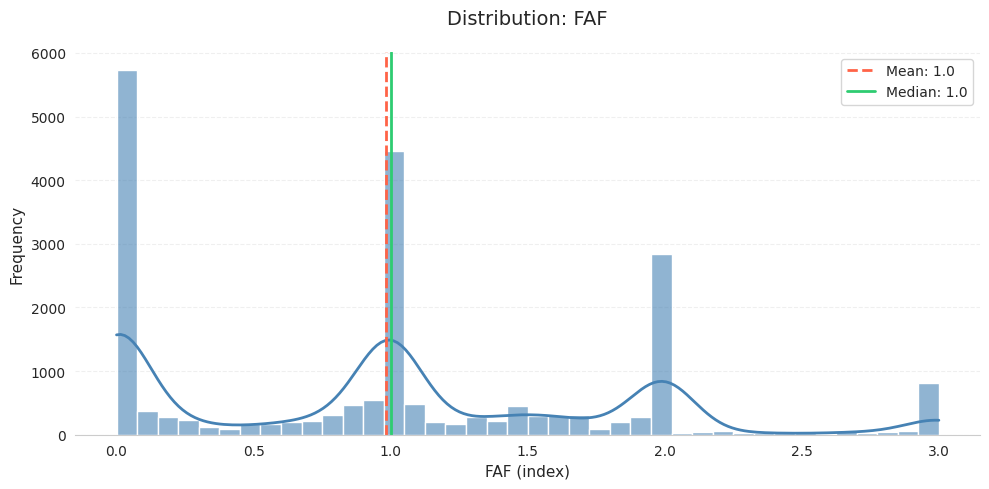

In [ ]:
plot_numerical_distribution(df, 'FAF', 'index')

**Analysis of the "Physical Activity" (FAF) Feature Distribution**

* **Low Activity Level:** The mean (**1.0**) and median (**1.0**) indicate that the typical respondent engages in physical exercise only 1–2 times per week. This suggests a predominance of a sedentary lifestyle within the overall sample.
* **Range and Variability:** Scores vary from **0.0** (complete lack of activity) to **3.0** (high activity). The standard deviation (**0.8**) shows that most responses are concentrated in a narrow range between "almost never" and "sometimes."
* **Distribution Shape:**
* **Skewness (0.5):** The positive coefficient confirms a right-skewed distribution—the bulk of the data is concentrated on the left side of the graph (low values), while the "tail" of active individuals is significantly smaller.
* **Kurtosis (-0.5):** The negative kurtosis indicates a platykurtic (flat-topped) distribution, suggesting the absence of a single dominant behavioral type: respondents are distributed fairly evenly across all activity levels without a distinct peak.
* **Absence of Outliers:** All values fall within the logical boundaries of the index (0–3); no anomalous data was detected. The data is ready for correlation analysis with weight categories.

In [ ]:
print("FAF ANALYSIS BY WEIGHT CATEGORIES")
display(get_feature_target_pivot(df, 'FAF'))

FAF ANALYSIS BY WEIGHT CATEGORIES


,Count,Mean,Median,Std,Min,Max
NObeyesdad,,,,,,
Obesity_Type_III,4046,0.5,0.0,0.7,0.0,2.9
Insufficient_Weight,2523,1.2,1.0,0.8,0.0,3.0
Obesity_Type_I,2910,0.9,1.0,0.9,0.0,3.0
Normal_Weight,3082,1.2,1.0,0.9,0.0,3.0
Obesity_Type_II,3248,1.0,1.0,0.5,0.0,3.0
Overweight_Level_I,2427,1.1,1.0,0.9,0.0,3.0
Overweight_Level_II,2522,1.1,1.0,0.8,0.0,3.0


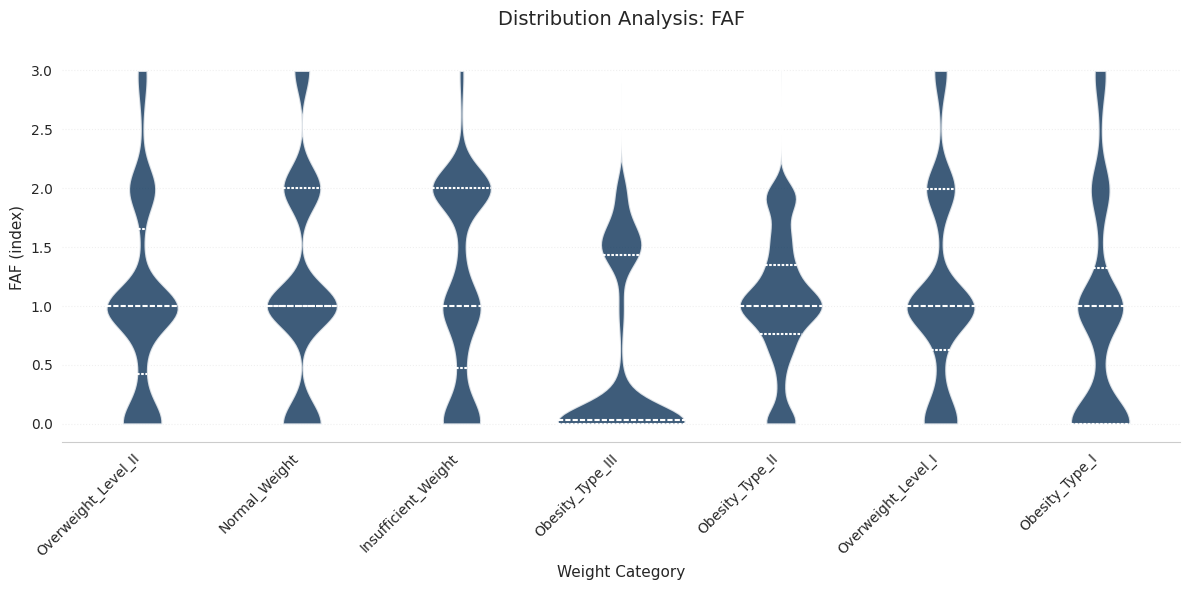

In [ ]:
plot_feature_by_target_dark(df, 'FAF', 'index')

**Conclusions on Physical Activity (FAF) by Weight Category**

* **Critical Activity Deficit in Obesity_Type_III:** The category with the most severe obesity level demonstrates the lowest metrics: a mean of **0.5** and a median of **0.0**. This means that more than half of the respondents in this group lead a completely sedentary lifestyle.
* **Consistency Across Other Groups:** Interestingly, in all other categories (from underweight to Obesity Type II), the median activity level remains constant at **1.0**. This suggests that moderate activity alone is not the sole differentiator between these weight types.
* **Homogeneity of the Obesity_Type_II Group:** This category shows the lowest dispersion (`Std = 0.5`), indicating highly similar behavior among all participants in this group—a consistently low level of physical exertion.
* **Potential for "Healthy" Habits:** In all groups, including those with obesity, the maximum value reaches **3.0**. This confirms the presence of active individuals even within high-BMI categories, which could be a significant factor for analyzing "metabolically healthy obesity."

## **5. Vegetable Consumption Feature Analysis (FCVC)**

In [ ]:
print("STATISTICAL SUMMARY: VEGETABLE CONSUMPTION")
fcvc_stats = get_numerical_summary(df, 'FCVC', 'index')
display(fcvc_stats)

STATISTICAL SUMMARY: VEGETABLE CONSUMPTION


,Metric,Value (index)
0,Total Count,20758.0
1,Missing Values,0.0
2,Missing Percentage (%),0.0
3,Mean,2.4
4,Median,2.4
5,Standard Deviation,0.5
6,Variance,0.3
7,Minimum,1.0
8,Maximum,3.0
9,Skewness,-0.4


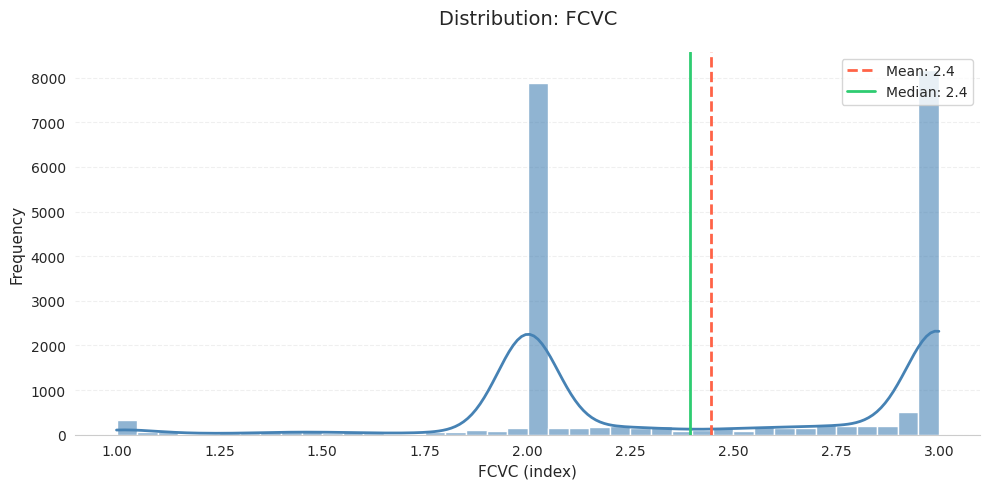

In [ ]:
plot_numerical_distribution(df, 'FCVC', 'index')

**Conclusions on the "Vegetable Consumption" (FCVC) Distribution**

* **High Average Level:** Both the mean (**2.4**) and median (**2.4**) are shifted toward the upper bound of the index (3.0). This suggests that the majority of respondents in the sample report regularly including vegetables in their diet.
* **Shift Toward Healthy Habits (Skewness = -0.4):** The negative skewness coefficient confirms a left-skewed distribution—the bulk of the data is concentrated in the high-value zone (2–3), while the number of people who consume almost no vegetables (index 1) is significantly lower.
* **Absence of a Dominant Peak (Kurtosis = -0.9):** The negative kurtosis indicates that the distribution is relatively uniform ("flat") within the 2 to 3 interval. This means there is no single dominant group, and responses are spread across the spectrum of medium to high values.
* **Data Stability:** The low standard deviation (**0.5**) and total absence of outliers indicate high consistency in the responses. Values are strictly confined within the logical range of 1 to 3.

In [ ]:
print("FCVC ANALYSIS BY WEIGHT CATEGORIES")
display(get_feature_target_pivot(df, 'FCVC'))

FCVC ANALYSIS BY WEIGHT CATEGORIES


,Count,Mean,Median,Std,Min,Max
NObeyesdad,,,,,,
Normal_Weight,3082,2.4,2.0,0.5,1.0,3.0
Obesity_Type_I,2910,2.1,2.0,0.4,1.0,3.0
Overweight_Level_II,2522,2.2,2.0,0.4,1.0,3.0
Overweight_Level_I,2427,2.3,2.0,0.5,1.0,3.0
Obesity_Type_II,3248,2.4,2.5,0.5,1.0,3.0
Insufficient_Weight,2523,2.5,2.8,0.6,1.0,3.0
Obesity_Type_III,4046,3.0,3.0,0.0,3.0,3.0


**Conclusions on Vegetable Consumption (FCVC) by Weight Category**

* **The Obesity_Type_III Anomaly:** This group demonstrates unique behavior: both the mean and median are exactly **3.0** with a standard deviation of zero (**Std = 0.0**). All 4,046 individuals in this category reported the maximum level of vegetable consumption.
* **Consumption Gradient:** The lowest vegetable consumption is observed in the `Obesity_Type_I` and `Overweight_Level_II` groups (median **2.0**).
* **Correlation with Underweight Status:** The high median value (**2.8**) in the `Insufficient_Weight` group confirms a correlation between high plant-based food intake and a low BMI.
* **Group Homogeneity:** Most categories exhibit a similar spread (Std 0.4–0.6), with the exception of severe obesity, where the data points are absolutely identical.

## **6. Number of Main Meals (NCP) Feature Analysis**

In [ ]:
print("STATISTICAL SUMMARY: NUMBER OF MAIN MEALS")
ncp_stats = get_numerical_summary(df, 'NCP', 'count')
display(ncp_stats)

STATISTICAL SUMMARY: NUMBER OF MAIN MEALS


,Metric,Value (count)
0,Total Count,20758.0
1,Missing Values,0.0
2,Missing Percentage (%),0.0
3,Mean,2.8
4,Median,3.0
5,Standard Deviation,0.7
6,Variance,0.5
7,Minimum,1.0
8,Maximum,4.0
9,Skewness,-1.6


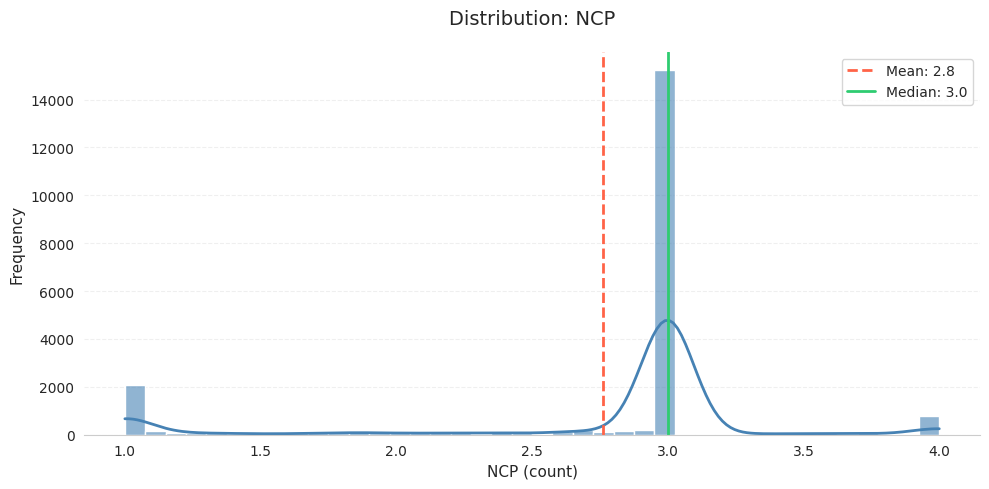

In [ ]:
plot_numerical_distribution(df, 'NCP', 'count')

**Conclusions on the "Number of Main Meals" (NCP) Distribution**

* **Dominant Standard:** The median (**3.0**) and mean (**2.8**) indicate that the vast majority of respondents adhere to the classic three-meal-a-day pattern.
* **Strong Left Skew (Skewness = -1.6):** The skewness coefficient shows that the bulk of the data is concentrated around 3–4 meals, while the "tail" of the distribution extends toward those who eat less frequently (1–2 times).
* **High Concentration and Peakedness (Kurtosis = 1.8):** The positive kurtosis confirms that the distribution has a sharp peak around the value of 3.0. This represents the "standard" behavior for this sample.
* **Statistical Anomaly with Outliers:** The program flagged a massive number of outliers (**6,052**) because the boundaries (Lower and Upper) collapsed at the value of **3.0**. This happens because the Interquartile Range (IQR) is zero (most responses are identical). From a medical perspective, these are not anomalies but simply individuals whose eating schedule differs from the most common value (those who eat 1, 2, or 4 times a day).

In [ ]:
print("NCP ANALYSIS BY WEIGHT CATEGORIES")
display(get_feature_target_pivot(df, 'NCP'))

NCP ANALYSIS BY WEIGHT CATEGORIES


,Count,Mean,Median,Std,Min,Max
NObeyesdad,,,,,,
Insufficient_Weight,2523,2.9,3.0,0.9,1.0,4.0
Normal_Weight,3082,2.9,3.0,0.7,1.0,4.0
Obesity_Type_I,2910,2.5,3.0,0.8,1.0,4.0
Obesity_Type_II,3248,2.8,3.0,0.5,1.0,4.0
Obesity_Type_III,4046,3.0,3.0,0.0,2.8,3.0
Overweight_Level_I,2427,2.5,3.0,0.9,1.0,4.0
Overweight_Level_II,2522,2.6,3.0,0.7,1.0,4.0


**Conclusions on the Number of Main Meals (NCP) Across Weight Categories**

* **Total Dominance of Three Meals a Day:** The median in **each and every** category is exactly **3.0**. This demonstrates that the traditional dietary pattern (breakfast, lunch, dinner) is a fundamental behavioral standard for the entire sample, regardless of Body Mass Index.
* **Anomalous Stability in Obesity_Type_III:** Similar to the vegetable consumption (FCVC) findings, the most severe obesity group shows almost zero variability (`Std ≈ 0.0`, with a narrow range of **2.8–3.0**). All 4,046 individuals in this group report eating exactly three times a day, which appears to be a statistical peculiarity of this specific dataset.
* **Tendency Toward Meal Deficit:** The categories `Obesity_Type_I` and `Overweight_Level_I` exhibit the lowest mean values (**2.5**). This suggests that individuals who skip meals (eating 1–2 times a day) are more common in groups with initial obesity and overweight status than in normal-weight groups.
* **Diversity of Eating Regimes:** The `Insufficient_Weight` and `Normal_Weight` groups show the highest variance and mean (**2.9**). These groups also more frequently include individuals who eat 4 times a day, which may point toward more frequent, fractional, and regular eating patterns among those without excess weight.

## **7. Water Consumption Feature Analysis (CH2O)**

In [ ]:
print("STATISTICAL SUMMARY: WATER CONSUMPTION")
water_stats = get_numerical_summary(df, 'CH2O', 'L')
display(water_stats)

STATISTICAL SUMMARY: WATER CONSUMPTION


,Metric,Value (L)
0,Total Count,20758.0
1,Missing Values,0.0
2,Missing Percentage (%),0.0
3,Mean,2.0
4,Median,2.0
5,Standard Deviation,0.6
6,Variance,0.4
7,Minimum,1.0
8,Maximum,3.0
9,Skewness,-0.2


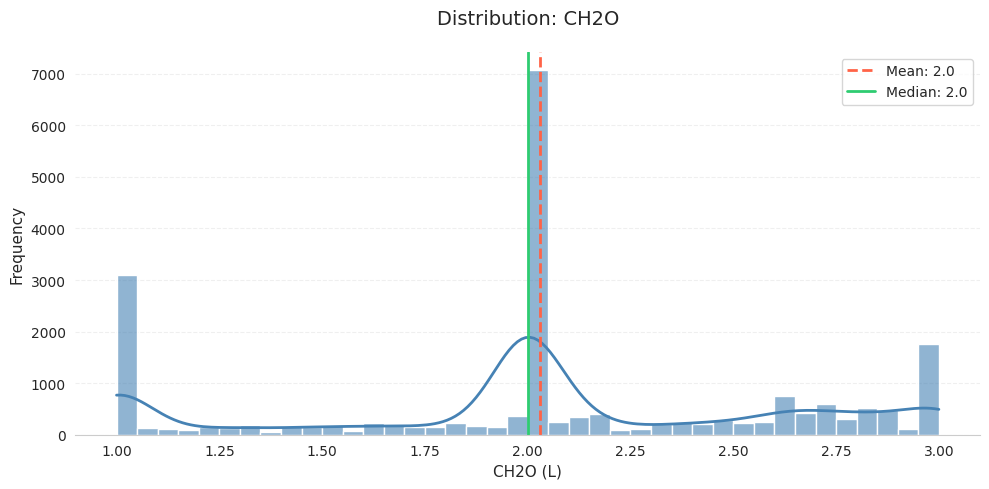

In [ ]:
plot_numerical_distribution(df, 'CH2O', 'L')

**Conclusions on the "Water Consumption" (CH2O) Distribution**

* **Optimal Average Level:** The mean and median are identical (**2.0 L**). This indicates that the average respondent in the sample adheres to the generally accepted daily fluid intake norm.
* **Balanced Sample (Skewness = -0.2):** The skewness coefficient is close to zero, with a slight tilt toward higher consumption. The distribution is nearly symmetrical: the number of people drinking less water (1 L) is balanced by those drinking more (3 L).
* **Uniform Distribution (Kurtosis = -0.7):** The negative kurtosis indicates the absence of a sharp peak. Responses are distributed fairly broadly across the entire range (1, 2, and 3 liters), which is characteristic of a diverse sample.
* **Data Integrity:** The standard deviation is **0.6 L**, which, combined with the absence of outliers, confirms the consistency and realism of the data. The minimum (**1.0**) and maximum (**3.0**) values fall within the physiological norm.

In [ ]:
print("CH2O ANALYSIS BY WEIGHT CATEGORIES")
display(get_feature_target_pivot(df, 'CH2O'))

CH2O ANALYSIS BY WEIGHT CATEGORIES


,Count,Mean,Median,Std,Min,Max
NObeyesdad,,,,,,
Insufficient_Weight,2523,1.7,2.0,0.6,1.0,3.0
Normal_Weight,3082,1.8,2.0,0.6,1.0,3.0
Obesity_Type_I,2910,2.1,2.0,0.6,1.0,3.0
Obesity_Type_II,3248,2.0,2.0,0.6,1.0,3.0
Overweight_Level_I,2427,2.1,2.0,0.6,1.0,3.0
Overweight_Level_II,2522,2.0,2.0,0.5,1.0,3.0
Obesity_Type_III,4046,2.3,2.6,0.6,1.0,3.0


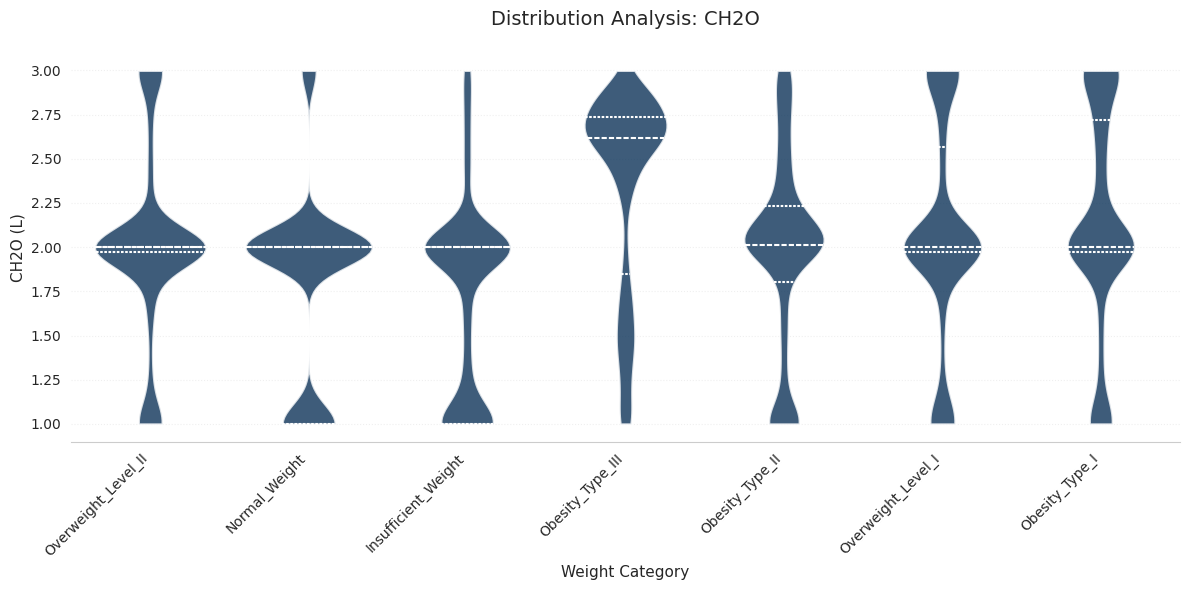

In [ ]:
plot_feature_by_target_dark(df, 'CH2O', 'L')

**Conclusions on Water Consumption (CH2O) across Weight Categories**

* **Uniformity of Habits:** The median water consumption is stable across almost all groups (from underweight to Obesity Type II) at **2.0 liters**. This suggests a lack of a direct linear relationship between hydration and weight category for the majority of participants.
* **Increased Consumption in Obesity_Type_III:** The group with the most severe obesity stands out with the highest metrics: a mean of **2.3 L** and a median of **2.6 L**. This may be due to the higher physiological water requirements of a body with a larger mass.
* **Minimum Metrics in Low-Weight Groups:** The lowest average values were recorded in the `Insufficient_Weight` (**1.7 L**) and `Normal_Weight` (**1.8 L**) categories, which also correlates with lower body mass and lower energy expenditure requirements.
* **High Data Stability:** The standard deviation is nearly identical across all groups (**0.5–0.6**), indicating a similar spread of drinking habits within each category.

## **8. Time Spent on Technology Devices (TUE) Feature Analysis**

In [ ]:
print("STATISTICAL SUMMARY: SCREEN TIME")
tue_stats = get_numerical_summary(df, 'TUE', 'index')
display(tue_stats)

STATISTICAL SUMMARY: SCREEN TIME


,Metric,Value (index)
0,Total Count,20758.0
1,Missing Values,0.0
2,Missing Percentage (%),0.0
3,Mean,0.6
4,Median,0.6
5,Standard Deviation,0.6
6,Variance,0.4
7,Minimum,0.0
8,Maximum,2.0
9,Skewness,0.7


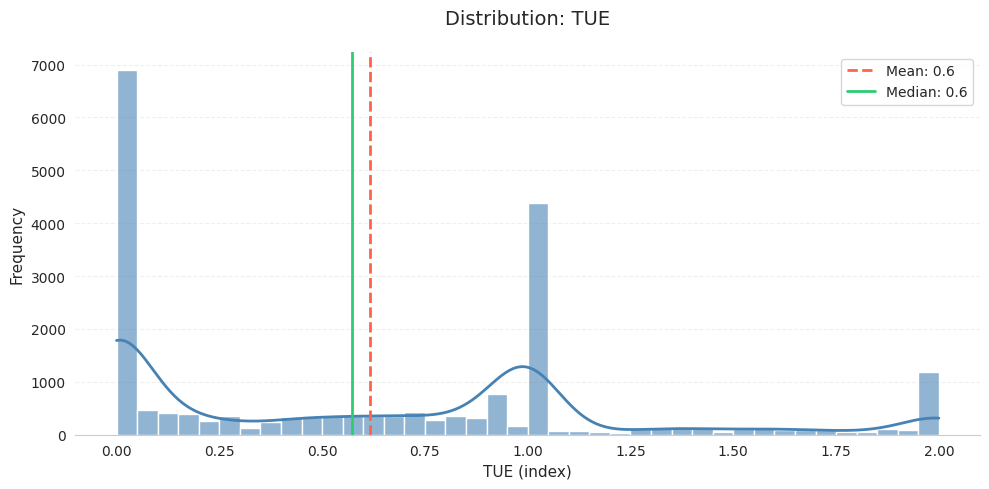

In [ ]:
plot_numerical_distribution(df, 'TUE', 'index')

**Conclusions on the "Screen Time" (TUE) Distribution**

* **Low Average Level:** The mean (**0.6**) and median (**0.6**) are located in the lower portion of the scale (0–2). This suggests that, on average, respondents spend a moderate amount of time on gadgets and television.
* **Right Skew (Skewness = 0.7):** The positive skewness indicates that the majority of individuals have a low technology usage index, while the group of "active users" (with an index closer to 2.0) is significantly smaller.
* **Uniformity of Distribution (Kurtosis = -0.4):** The negative kurtosis suggests that the data is distributed relatively "flatly" across the available range. There is no single prominent peak, indicating that respondents' habits are quite varied.
* **Absence of Anomalies:** All data points fall within the permissible range (**0.0 – 2.0**), and there are no outliers. This makes the feature reliable for further analysis of its relationship with physical activity.

In [ ]:
print("TUE ANALYSIS BY WEIGHT CATEGORIES")
display(get_feature_target_pivot(df, 'TUE'))

TUE ANALYSIS BY WEIGHT CATEGORIES


,Count,Mean,Median,Std,Min,Max
NObeyesdad,,,,,,
Obesity_Type_II,3248,0.4,0.1,0.5,0.0,2.0
Overweight_Level_I,2427,0.6,0.1,0.7,0.0,2.0
Obesity_Type_III,4046,0.5,0.6,0.3,0.0,2.0
Obesity_Type_I,2910,0.7,0.7,0.7,0.0,2.0
Overweight_Level_II,2522,0.7,0.9,0.6,0.0,2.0
Normal_Weight,3082,0.6,1.0,0.6,0.0,2.0
Insufficient_Weight,2523,0.8,1.0,0.7,0.0,2.0


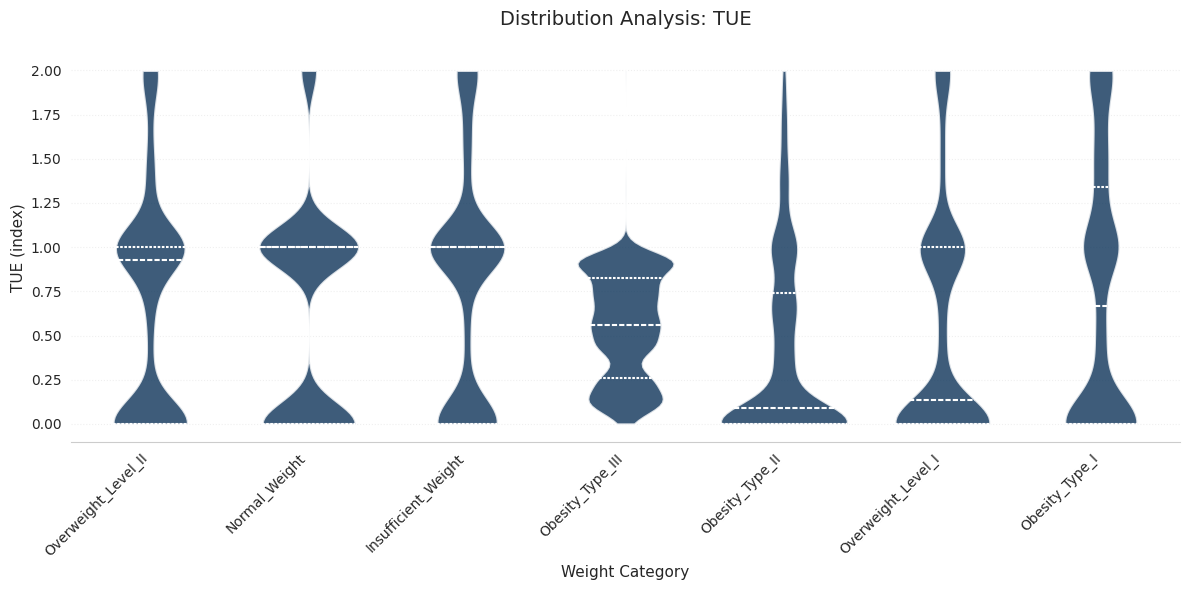

In [ ]:
plot_feature_by_target_dark(df, 'TUE', 'index')

**Conclusions on Screen Time (TUE) across Weight Categories**

* **Inverse Relationship:** There is an interesting trend—the median screen time is **higher** in lower-weight groups. For the `Normal_Weight` and `Insufficient_Weight` categories, the median is **1.0**, while it is significantly lower for the heaviest obesity categories.
* **Minimum in Obesity_Type_II:** The Obesity Type II group demonstrates the lowest technology usage (median **0.1**). This may indicate that gadgets are not the primary factor contributing to a sedentary lifestyle for this group.
* **Obesity_Type_III Specifics:** In the most severe obesity category, the median is **0.6**, and the dispersion is the lowest (`Std = 0.3`). This suggests high homogeneity within the group: almost all respondents spend a moderate, consistently average amount of time in front of a screen.
* **Gap in Habits:** The `Overweight_Level_II` and `Normal_Weight` groups have medians of **0.9** and **1.0**, respectively, indicating that digital leisure is more characteristic of individuals with moderate or normal weight in this dataset.

---

**Lifestyle Block Summary**

1. **Physical Activity (FAF):** Drops to zero in cases of severe obesity.
2. **Vegetables (FCVC) and Meals (NCP):** Show abnormally "correct" values in the Obesity III group.
3. **Water (CH2O):** Consumption increases alongside body mass.
4. **Gadgets (TUE):** Paradoxically higher among people with normal and low weight.


# **Categorical Feature Analysis of the Dataset**

## **1. Binary Feature Distribution Analysis**

In [ ]:
BINARY_FEAT = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
BIN_TRANS = {
    'Gender': 'Gender',
    'family_history_with_overweight': 'Family History',
    'FAVC': 'High-Calorie Food',
    'SMOKE': 'Smoking',
    'SCC': 'Calorie Monitoring'
}

bin_data = []
for f in BINARY_FEAT:
    s = df[f].value_counts()
    for i, (val, count) in enumerate(s.items()):
        bin_data.append({
            'Feature': BIN_TRANS[f],
            'Class': val,
            'Count': count,
            'Percentage (%)': round(count/len(df)*100, 1),
            'Mode': s.index[0] if i==0 else '',
            'Imbalance': f"1:{round(s.max()/s.min(),1)}" if i==0 else ''
        })

display(HTML(custom_style + generate_styled_table(pd.DataFrame(bin_data), "BINARY FEATURES")))

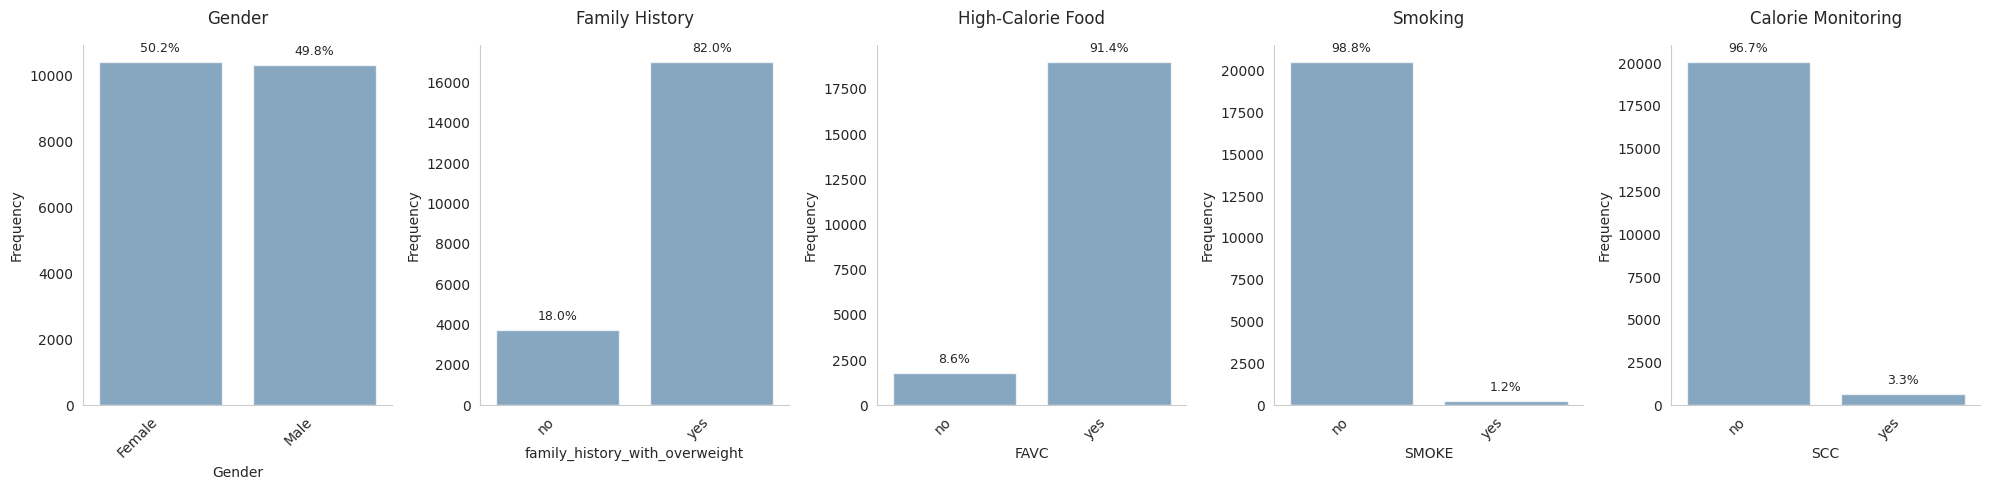

In [ ]:
plot_categorical_grid(df, BINARY_FEAT, BIN_TRANS, colors='#4682B4')

The group of binary features demonstrates both perfectly balanced metrics and variables with extreme distributions:

* **Gender Balance:** The **"Gender"** feature is distributed almost equally (**50.2%** female vs. **49.8%** male). This ensures that the resulting model will be trained equally well on data from both genders without gender bias.
* **Key Risk Factors:** A high concentration of negative factors is observed. **82%** of respondents have a **family history** of overweight, and **91.4%** regularly consume **high-calorie food**. These features are likely to be the most significant predictors for determining obesity levels.
* **Low Popularity of Healthy Habits:** The **"Calorie Monitoring" (SCC)** feature showed a critically low value—only **3.3%** of participants track their diet. An imbalance of **1:29.2** makes this group small, but potentially important for identifying the "Normal Weight" category.
* **Health Habits (Smoking):** The vast majority of respondents (**98.8%**) do not smoke. The high imbalance (**1:83.7**) indicates that the smoking factor in this sample has almost no impact on the overall data variability and may carry minimal weight in the final model.

### **Gender Feature Analysis**

In [ ]:
print("ANALYSIS OF GENDER DISTRIBUTION BY WEIGHT CATEGORIES")
gender_target_pivot = pd.crosstab(df['NObeyesdad'], df['Gender'], normalize='index') * 100
display(gender_target_pivot.round(1))

ANALYSIS OF GENDER DISTRIBUTION BY WEIGHT CATEGORIES


Gender,Female,Male
NObeyesdad,,
Insufficient_Weight,64.2,35.8
Normal_Weight,53.9,46.1
Obesity_Type_I,43.5,56.5
Obesity_Type_II,0.2,99.8
Obesity_Type_III,99.9,0.1
Overweight_Level_I,44.1,55.9
Overweight_Level_II,29.9,70.1


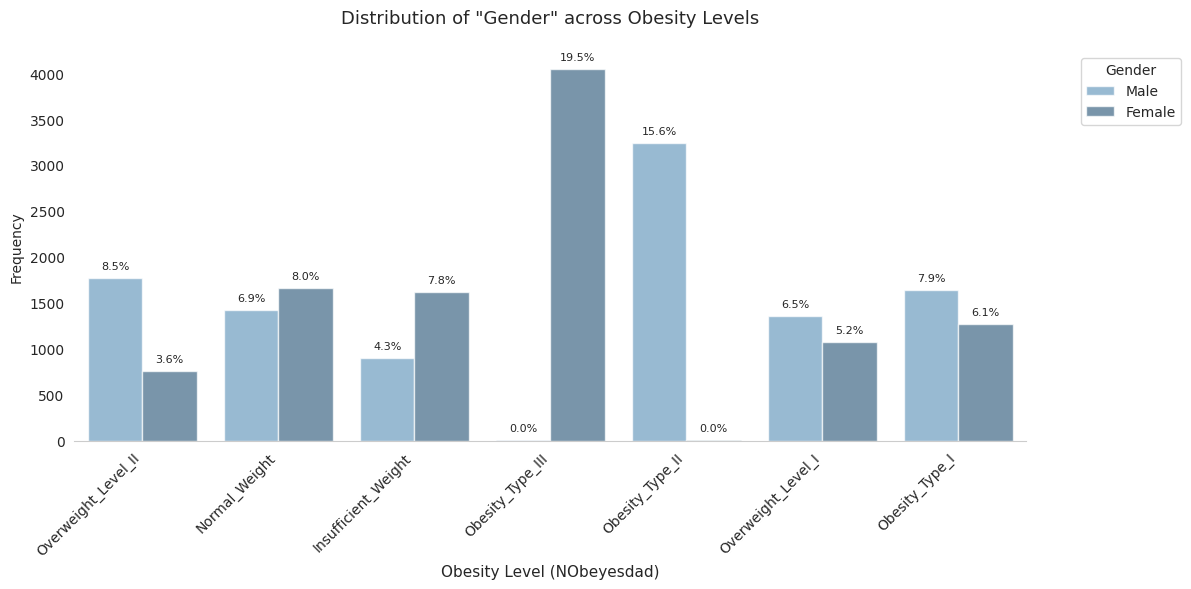

In [ ]:
gender_trans = {'Gender': 'Gender'}
plot_target_by_categorical(df, ['Gender'], translations=gender_trans)

**Conclusions on Gender Analysis across Weight Categories**

1. **Extreme Gender Segmentation in Severe Obesity:** There is a near-absolute gender split in the highest obesity categories:
* **Obesity Type II** is represented almost entirely (**99.8%**) by **men**.
* **Obesity Type III** is represented almost entirely (**99.9%**) by **women**.
This indicates that in this dataset, gender is a decisive factor for classifying severe forms of obesity.


2. **Underweight Category:** The **Insufficient Weight** category is predominantly represented by **women (64.2%)**, which may reflect biological differences or varying social perceptions regarding body mass among respondents.
3. **Overweight Categories:** Men predominate in the pre-obesity stages (Level I and II). Notably, in **Overweight Level II**, the male proportion reaches **70.1%**, which is significantly higher than in Level I.
4. **Normal Weight:** This category is the most balanced, although the proportion of women is slightly higher (**53.9%**).

### **Family History Feature Analysis (family_history_with_overweight)**

In [ ]:
print("FAMILY HISTORY ANALYSIS BY WEIGHT CATEGORIES")
family_pivot = pd.crosstab(df['NObeyesdad'], df['family_history_with_overweight'], normalize='index') * 100
display(family_pivot.round(2))

FAMILY HISTORY ANALYSIS BY WEIGHT CATEGORIES


family_history_with_overweight,no,yes
NObeyesdad,,
Insufficient_Weight,57.43,42.57
Normal_Weight,41.92,58.08
Obesity_Type_I,1.65,98.35
Obesity_Type_II,0.15,99.85
Obesity_Type_III,0.02,99.98
Overweight_Level_I,31.15,68.85
Overweight_Level_II,7.65,92.35


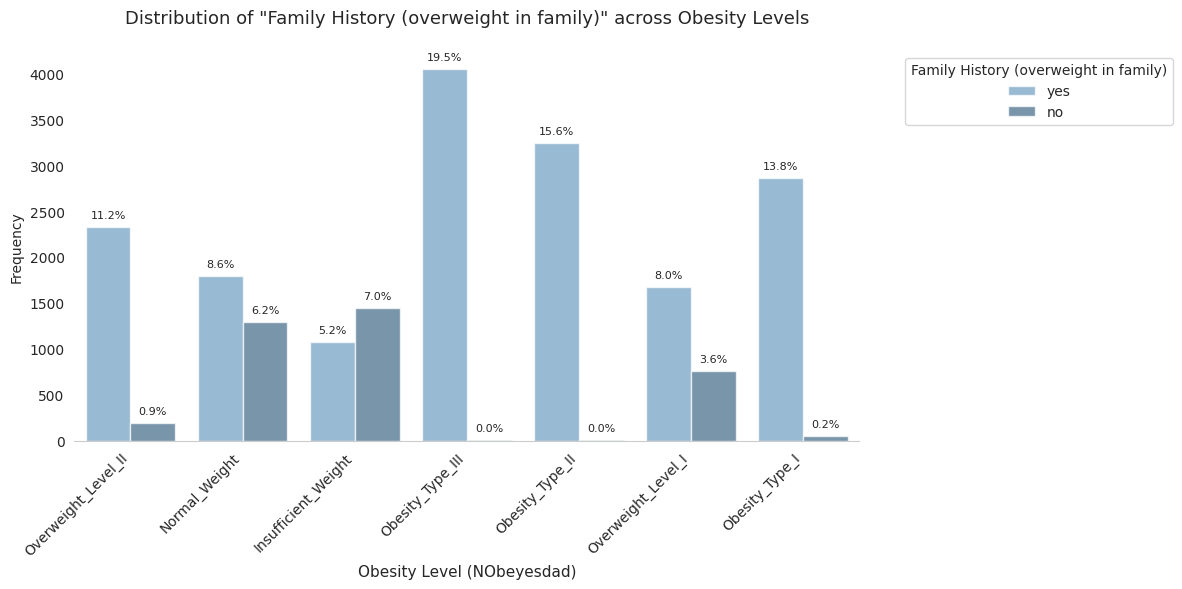

In [ ]:
family_trans = {'family_history_with_overweight': 'Family History (overweight in family)'}
plot_target_by_categorical(df, ['family_history_with_overweight'], translations=family_trans)

**Conclusions on Family History Analysis across Weight Categories**

* **Critical Marker for Severe Obesity:** In the **Obesity Type II** and **Obesity Type III** categories, the presence of a family history of obesity is nearly **100%** (**99.85%** and **99.98%**, respectively). This implies that in this dataset, severe obesity almost never occurs without a genetic or familial predisposition.
* **Threshold Jump:** A sharp transition is observed between the `Normal Weight` category (where family history is present in **58%** of cases) and `Obesity Type I` (where the figure skyrockets to **98%**). This suggests that the family factor is a key "trigger" for the transition from simply being overweight to clinical obesity.
* **"Protective" Effect of Negative History:** The **Insufficient Weight** group is the only one where the majority (**57.4%**) do not have a family history of obesity. This confirms a direct correlation: the absence of predisposition significantly increases the chances of maintaining a low or normal body weight.
* **Progression Dynamics:** We observe a clear stepwise correlation:
* *Normal:* ~58%
* *Overweight:* 69% → 92%
* *Obesity:* 98% → 100%
The genetic factor intensifies proportionally to the increase in body mass.

### **High-Calorie Food Consumption Feature Analysis (FAVC)**

In [ ]:
print("FAVC ANALYSIS BY WEIGHT CATEGORIES")
favc_target_pivot = pd.crosstab(df['NObeyesdad'], df['FAVC'], normalize='index') * 100
display(favc_target_pivot)

FAVC ANALYSIS BY WEIGHT CATEGORIES


FAVC,no,yes
NObeyesdad,,
Insufficient_Weight,14.665081,85.334919
Normal_Weight,16.060999,83.939001
Obesity_Type_I,3.195876,96.804124
Obesity_Type_II,1.662562,98.337438
Obesity_Type_III,0.024716,99.975284
Overweight_Level_I,9.229501,90.770499
Overweight_Level_II,21.371927,78.628073


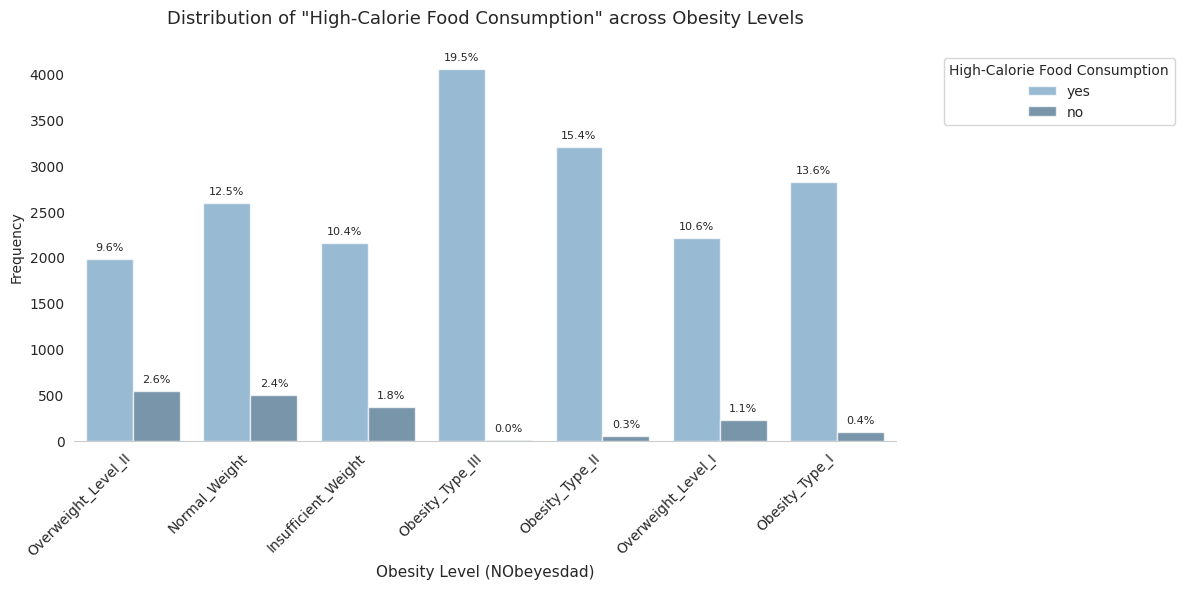

In [ ]:
favc_trans = {'FAVC': 'High-Calorie Food Consumption'}
plot_target_by_categorical(df, ['FAVC'], translations=favc_trans)

**Conclusions on FAVC Analysis across Weight Categories**

* **Direct Correlation with Obesity:** The percentage of high-calorie food consumption reaches critical levels in the obesity groups. In the **Obesity_Type_III** category, it is practically **100%** (99.98%), and in **Obesity_Type_II**, it stands at **98.3%**. This confirms that high-calorie food is a fundamental factor in severe forms of obesity.
* **The Overweight_Level_II Anomaly:** This group demonstrates the highest rate of avoiding high-calorie food (**21.4%**—even higher than individuals with normal weight). This may indicate that respondents in this category are more likely than others to attempt dietary control, as they are on the "threshold" of transitioning to obesity.
* **Healthy Deficit:** In the `Insufficient_Weight` and `Normal_Weight` categories, the proportion of those who avoid high-calorie food is approximately **15–16%**. This is 5 to 10 times higher than in the obesity groups, highlighting the protective role of healthy eating habits.
* **Risk Marker:** The sharp decline in "No" responses (down to **3.2%**) when moving from overweight to `Obesity_Type_I` serves as a clear indicator that losing control over diet quality leads to the clinical obesity stage.

### **Smoking Feature Analysis (SMOKE)**

In [ ]:
print("SMOKE ANALYSIS BY WEIGHT CATEGORIES")
smoke_pivot = pd.crosstab(df['NObeyesdad'], df['SMOKE'], normalize='index') * 100
display(smoke_pivot)

SMOKE ANALYSIS BY WEIGHT CATEGORIES


SMOKE,no,yes
NObeyesdad,,
Insufficient_Weight,99.722553,0.277447
Normal_Weight,98.507463,1.492537
Obesity_Type_I,99.175258,0.824742
Obesity_Type_II,96.490148,3.509852
Obesity_Type_III,99.901137,0.098863
Overweight_Level_I,98.969922,1.030078
Overweight_Level_II,99.008723,0.991277


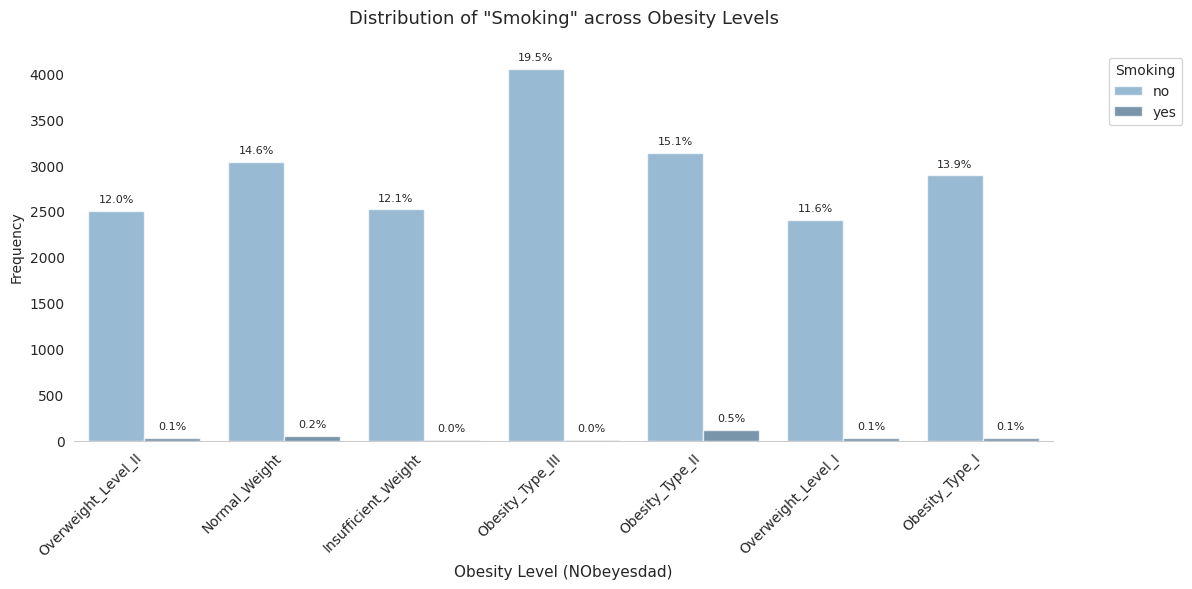

In [ ]:
smoke_trans = {'SMOKE': 'Smoking'}
plot_target_by_categorical(df, ['SMOKE'], translations=smoke_trans)

**Conclusions on Smoking Analysis across Weight Categories**

* **Extremely Low Prevalence:** Smoking is not a defining factor in this dataset. On average, over **98%** of respondents in every category are non-smokers. This makes the "SMOKE" feature statistically weak for weight prediction.
* **Peak in Obesity Type II:** The highest percentage of smokers is recorded in the **Obesity_Type_II** group (**3.5%**). This is the only segment where the proportion of smokers significantly deviates from the sample average.
* **Minimum in Obesity Type III:** In the most severe obesity category, the percentage of smokers is practically zero (**0.1%**). This may indicate that upon reaching critical body mass, smoking is either replaced by food addictions or excluded due to health conditions.
* **Appetite Suppression Myth:** The data does not support the theory that smoking helps maintain low weight—in the **Insufficient_Weight** category, only **0.3%** of people smoke, which is nearly 5 times less than in the normal weight group.

### **Calorie Monitoring Feature Analysis (SCC)**

In [ ]:
print("SCC ANALYSIS BY WEIGHT CATEGORIES")
scc_pivot = pd.crosstab(df['NObeyesdad'], df['SCC'], normalize='index') * 100
display(scc_pivot)

SCC ANALYSIS BY WEIGHT CATEGORIES


SCC,no,yes
NObeyesdad,,
Insufficient_Weight,90.804598,9.195402
Normal_Weight,94.808566,5.191434
Obesity_Type_I,99.381443,0.618557
Obesity_Type_II,99.876847,0.123153
Obesity_Type_III,100.000000,0.000000
Overweight_Level_I,89.740420,10.259580
Overweight_Level_II,99.048374,0.951626


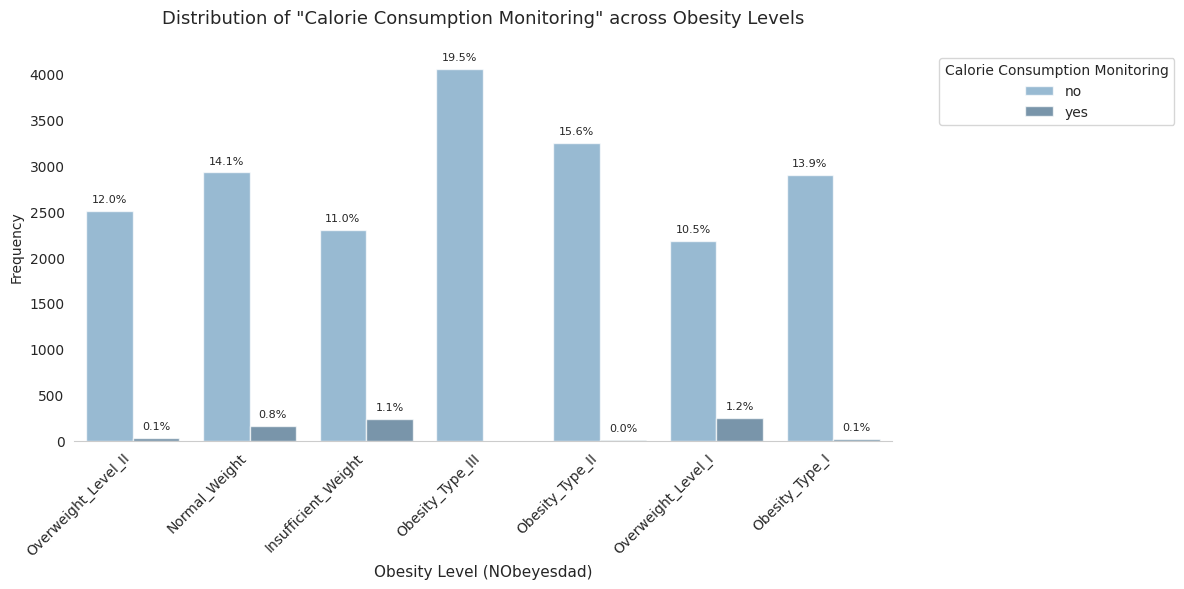

In [ ]:
scc_trans = {'SCC': 'Calorie Consumption Monitoring'}
plot_target_by_categorical(df, ['SCC'], translations=scc_trans)

**Conclusions on SCC Analysis across Weight Categories**

* **Lack of Control in Obesity:** A critical trend is observed—the higher the degree of obesity, the less likely respondents are to monitor their calories. In the **Obesity_Type_III** category, monitoring is entirely non-existent (**0%**), and in **Obesity_Type_II**, it is nearly zero (**0.1%**). This makes SCC one of the strongest differentiators between normal weight and severe obesity.
* **Peak Awareness in Overweight I:** The highest level of calorie monitoring was recorded in the **Overweight_Level_I** group (**10.3%**). This supports the hypothesis that individuals who have just begun to gain excess weight try to combat it using self-control tools.
* **Discipline in Underweight Status:** The **Insufficient_Weight** group also demonstrates a high rate (**9.2%**), which may be associated with attempts to gain weight through strict nutritional tracking.
* **General Trend:** The vast majority of respondents in all categories (over **90%**) **do not** track their calories. However, the near-total disappearance of this feature in obesity groups (Type I, II, III) indicates that a lack of monitoring is a concomitant factor in the progression of the condition.

## **2. Ordinal and Nominal Feature Distribution Analysis**

In [ ]:
ORD_FEAT = ['CAEC', 'CALC', 'MTRANS']
ORD_TRANS = {'CAEC': 'Snacking', 'CALC': 'Alcohol', 'MTRANS': 'Transportation'}

ord_data = []
for f in ORD_FEAT:
    s = df[f].value_counts()
    for i, (val, count) in enumerate(s.items()):
        ord_data.append({
            'Feature': ORD_TRANS[f],
            'Class': val,
            'Count': count,
            'Percentage (%)': round(count/len(df)*100, 1),
            'Mode': s.index[0] if i==0 else '',
            'Imbalance': f"1:{round(s.max()/s.min(),1)}" if i==0 else ''
        })

display(HTML(custom_style + generate_styled_table(pd.DataFrame(ord_data), "ORDINAL AND NOMINAL FEATURES")))

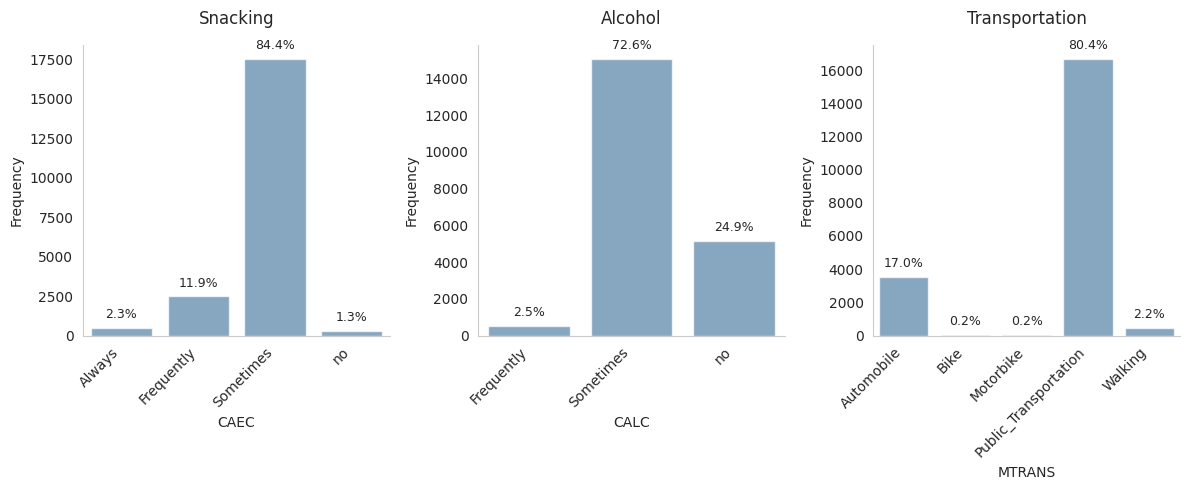

In [ ]:
plot_categorical_grid(df, ORD_FEAT, ORD_TRANS, colors='#4682B4')

These metrics characterize the lifestyles and behavioral patterns of the respondents. There is a pronounced dominance of specific classes across all three features:

* **Eating Behavior (Snacking):** The sample is highly homogeneous—**84.4%** of respondents snack **"Sometimes."** The extremely low percentage of people who completely abstain from snacking (**1.3%**), combined with a high imbalance ratio (**1:62.8**), indicates that this habit is the norm for the majority of study participants.
* **Alcohol Consumption:** The majority of respondents (**72.6%**) consume alcohol moderately. Meanwhile, a quarter of the sample (**24.9%**) reports complete abstinence. The imbalance of **1:28.5** is driven by the very small number of individuals who consume alcohol frequently, which is typical for self-reported survey data.
* **Transportation Activity:** There is a critical tilt toward **public transportation (80.4%)**. Active modes of travel (walking or cycling) combined account for less than **2.5%**. This indicates a low level of daily physical activity associated with commuting, which is a major risk factor for developing obesity.

The high imbalance in these features (especially in transportation and snacking) means that rare classes (e.g., "bike" or "no snacking") may serve as strong markers for specific groups if they correlate with normal weight.

### **Alcohol Consumption Feature Analysis (CALC)**

In [ ]:
print("CALC ANALYSIS BY WEIGHT CATEGORIES")
calc_pivot = pd.crosstab(df['NObeyesdad'], df['CALC'], normalize='index') * 100
display(calc_pivot)

CALC ANALYSIS BY WEIGHT CATEGORIES


CALC,Frequently,Sometimes,no
NObeyesdad,,,
Insufficient_Weight,0.554895,64.209275,35.235830
Normal_Weight,2.206360,62.946139,34.847502
Obesity_Type_I,2.611684,49.621993,47.766323
Obesity_Type_II,0.400246,85.498768,14.100985
Obesity_Type_III,0.000000,100.000000,0.000000
Overweight_Level_I,5.356407,80.758138,13.885455
Overweight_Level_II,9.040444,50.713719,40.245837


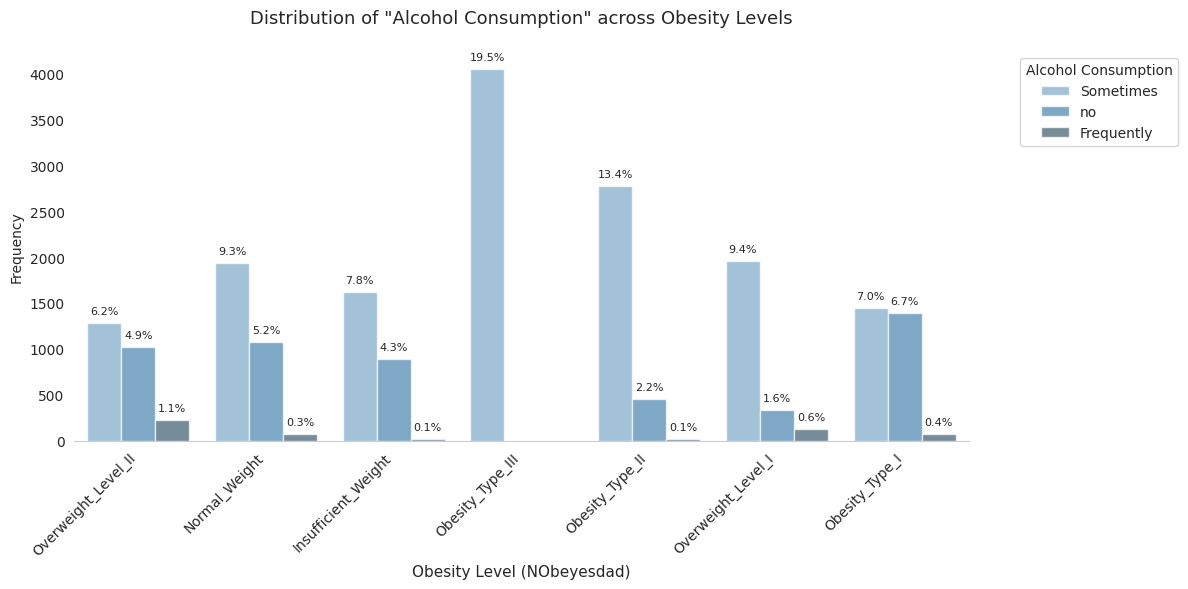

In [ ]:
calc_trans = {'CALC': 'Alcohol Consumption'}
plot_target_by_categorical(df, ['CALC'], translations=calc_trans)

**Conclusions on Alcohol Analysis across Weight Categories**

* **Obesity Type III Anomaly:** The most severe obesity category demonstrates a unique distribution—**100%** of respondents consume alcohol "sometimes" (`Sometimes`). Notably, there are no absolute teetotalers nor frequent drinkers in this group. This indicates an extraordinary homogeneity of habits within this segment.
* **Peak of Frequent Use in Overweight II:** The highest percentage of the `Frequently` category (**9.0%**) is observed in the **Overweight_Level_II** group. This may suggest that regular alcohol consumption is a significant factor in weight gain specifically during the transition from being overweight to clinical obesity.
* **Sobriety and Obesity Type I:** Surprisingly, the **Obesity_Type_I** category recorded the highest level of complete alcohol abstinence (**47.8%**). This might indicate attempts at medical weight correction or the presence of comorbid conditions that preclude alcohol use.
* **The General "Sometimes" Trend:** For most categories (except Obesity I), consuming alcohol "from time to time" is the dominant norm (**50–85%**). This confirms that alcohol is present in the diets of most individuals with excess body mass, contributing to overall caloric intake.

### **Transportation Mode Feature Analysis (MTRANS)**

In [ ]:
print("MTRANS ANALYSIS BY WEIGHT CATEGORIES")
mtrans_pivot = pd.crosstab(df['NObeyesdad'], df['MTRANS'], normalize='index') * 100
display(mtrans_pivot.round(2))

MTRANS ANALYSIS BY WEIGHT CATEGORIES


MTRANS,Automobile,Bike,Motorbike,Public_Transportation,Walking
NObeyesdad,,,,,
Insufficient_Weight,10.98,0.08,0.16,85.85,2.93
Normal_Weight,10.03,0.45,0.55,83.23,5.74
Obesity_Type_I,25.67,0.07,0.14,73.26,0.86
Obesity_Type_II,29.06,0.03,0.09,70.63,0.18
Obesity_Type_III,0.00,0.00,0.00,100.00,0.00
Overweight_Level_I,19.57,0.37,0.29,75.61,4.16
Overweight_Level_II,31.01,0.16,0.12,65.38,3.33


**Conclusions on Transportation Analysis across Weight Categories**

* **Total Dependence in Obesity Type III:** Similar to the alcohol consumption patterns, the group with the most severe obesity demonstrates absolute homogeneity—**100%** of respondents use public transportation. The complete absence of personal vehicles or walking in this group may be related to socio-economic factors or data collection specifics within this particular sub-population.
* **Private Cars as a Risk Factor:** There is a clear increase in automobile usage when moving from normal weight to overweight categories. In the **Obesity Type I** and **Obesity Type II** groups, the share of car users reaches **25–29%**, peaking in **Overweight Level II** at **31%**. This supports the hypothesis that a decrease in baseline activity (replacing walking with driving) correlates with excess weight.
* **Underweight Status and Activity:** The highest levels of **Walking** were recorded among individuals with normal weight (**5.7%**) and insufficient weight (**2.9%**). As obesity progresses (Types I–III), this metric drops nearly to zero (less than 1%), indicating a sharp reduction in spontaneous physical activity.
* **Public Transport as the Primary Mode:** For most categories, this is the dominant mode of travel (ranging from 65% to 85%). However, its share decreases in overweight groups as respondents transition to using private automobiles.

### **Snacking Frequency Feature Analysis (CAEC)**

In [ ]:
print("CAEC ANALYSIS BY WEIGHT CATEGORIES")
caec_pivot = pd.crosstab(df['NObeyesdad'], df['CAEC'], normalize='index') * 100
display(caec_pivot.round(2))

CAEC ANALYSIS BY WEIGHT CATEGORIES


CAEC,Always,Frequently,Sometimes,no
NObeyesdad,,,,
Insufficient_Weight,1.39,48.04,50.26,0.32
Normal_Weight,8.92,22.91,67.00,1.17
Obesity_Type_I,2.20,1.92,95.60,0.27
Obesity_Type_II,0.31,0.37,99.26,0.06
Obesity_Type_III,0.02,0.07,99.90,0.00
Overweight_Level_I,2.47,11.25,77.26,9.02
Overweight_Level_II,1.31,8.33,90.13,0.24


**Conclusions on Snacking Habits (CAEC) Analysis across Weight Categories**

* **Dominance of "Sometimes" in Obesity Groups:** In the most severe obesity categories (**Obesity Type II and III**), nearly **100%** of respondents (99.26% and 99.90%) state that they only snack "sometimes" (`Sometimes`). This appears to be a statistical anomaly or "social desirability bias," as the complete absence of `Frequently` and `Always` categories in these groups contradicts classical dietetics.
* **The Underweight Phenomenon:** The **Insufficient Weight** group is the only one where almost half of the respondents (**48%**) admit to snacking "frequently" (`Frequently`). This may be related to metabolic characteristics (frequent small meals) or the specific composition of these snacks, which do not result in weight gain.
* **Normal Weight and "Always":** The highest percentage of the `Always` category (constant snacking) is observed among individuals with **Normal Weight** (**8.9%**). This suggests that the act of snacking itself is less important than total caloric intake and physical activity.
* **Abstaining from Snacks (No):** Interestingly, the `no` category (never snacking) is most prominent in the **Overweight Level I** group (**9%**). In all other groups, this metric is close to zero.
* **General Trend:** As the degree of obesity increases, responses become increasingly uniform—the vast majority select the `Sometimes` option, virtually excluding extremes like `no` or `Always`.

## **3. Target Variable Distribution Analysis**

In [ ]:
target_s = df['NObeyesdad'].value_counts()
target_data = []
for i, (val, count) in enumerate(target_s.items()):
    target_data.append({
        'Feature': 'Target Variable',
        'Class': val,
        'Count': count,
        'Percentage (%)': round(count/len(df)*100, 1),
        'Mode': target_s.index[0] if i==0 else '',
        'Imbalance': f"1:{round(target_s.max()/target_s.min(),1)}" if i==0 else ''
    })

display(HTML(custom_style + generate_styled_table(pd.DataFrame(target_data), "TARGET VARIABLE (NOBEYESDAD)")))

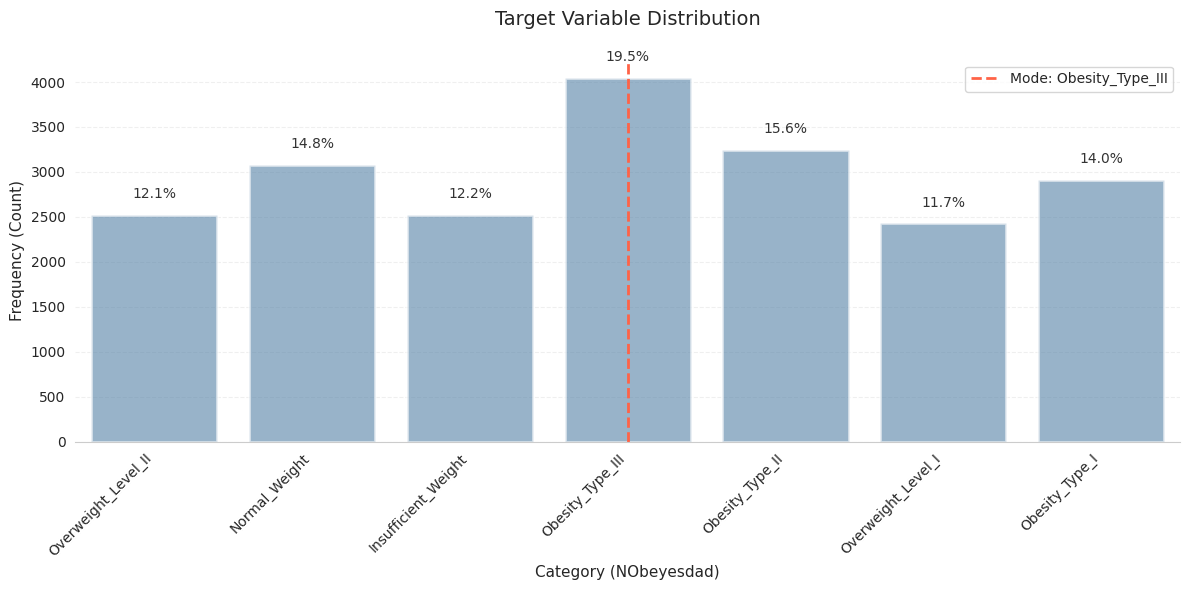

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df,
    x='NObeyesdad',
    color='#4682B4',
    alpha=0.6,
    edgecolor='white',
    linewidth=2
)

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom',
                xytext=(0, 10), textcoords='offset points',
                fontsize=10, color='#333')

mode_category = target_s.index[0]
mode_idx = list(ax.get_xticklabels()).index(next(label for label in ax.get_xticklabels() if label.get_text() == mode_category))
plt.axvline(mode_idx, color='#FF6347', linestyle='--', linewidth=2, label=f'Mode: {mode_category}')

plt.xticks(rotation=45, ha='right')
plt.title('Target Variable Distribution', fontsize=14, pad=25)
plt.xlabel('Category (NObeyesdad)', fontsize=11)
plt.ylabel('Frequency (Count)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(frameon=True, loc='upper right')

sns.despine(left=True)
plt.tight_layout()
plt.show()

**Conclusions based on the analysis results:**

* **Sample Balance:** The dataset demonstrates a **high degree of balance**. The proportion of each of the seven weight categories varies within a narrow range from **11.7%** to **19.5%**. This is an excellent indicator for training machine learning models, as there is no critical bias toward any single class.
* **Dominant Class (Mode):** The most represented category is **Obesity_Type_III**, accounting for **19.5%** (4,046 records).
* **Imbalance Ratio:** The imbalance ratio is only **1:1.7** (the ratio of the smallest class, *Overweight_Level_I*, to the largest, *Obesity_Type_III*). Such a value is considered insignificant and does not require the application of special resampling techniques (like SMOTE or Undersampling).
* **Group Structure:** Collectively, the categories classified as "Obesity" (Type I, II, III) make up nearly **50%** of the sample, making this dataset a specialized tool for studying severe forms of excess body mass.

# **Correlation**

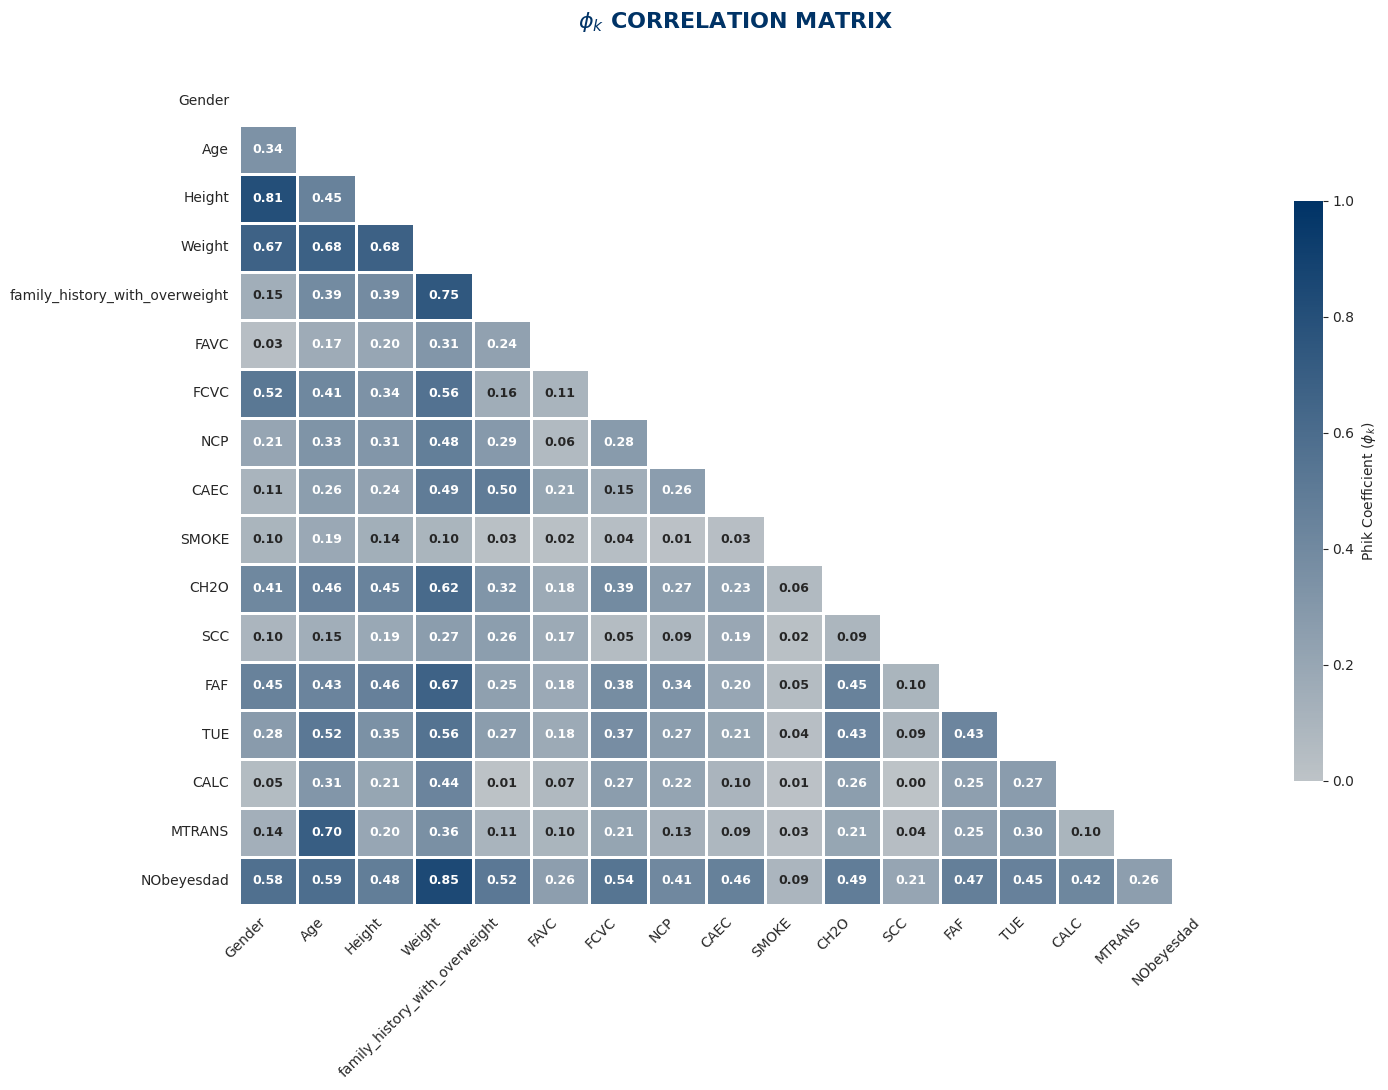

In [ ]:
interval_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
phik_matrix = df.phik_matrix(interval_cols=interval_cols)

my_cmap = LinearSegmentedColormap.from_list("custom_blue", ["#BDC3C7", "#003366"])

plt.figure(figsize=(15, 11), facecolor='white')
sns.set_style("white")
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

sns.heatmap(
    phik_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=my_cmap,
    vmin=0, vmax=1,
    linewidths=1,
    cbar_kws={"shrink": .7, "label": r"Phik Coefficient ($\phi_k$)"},
    annot_kws={"size": 9, "weight": "bold"}
)

plt.title(r'$\phi_k$ CORRELATION MATRIX',
          fontsize=16, pad=35, weight='bold', color='#003366', loc='center')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [ ]:
print("\nRANKING ALL FEATURES BY INFLUENCE ON WEIGHT (NObeyesdad):")
phik_matrix['NObeyesdad'].sort_values(ascending=False)


RANKING ALL FEATURES BY INFLUENCE ON WEIGHT (NObeyesdad):


NObeyesdad                        1.000000
Weight                            0.846584
Age                               0.590662
Gender                            0.575421
FCVC                              0.544278
family_history_with_overweight    0.517981
CH2O                              0.487920
Height                            0.480604
FAF                               0.470832
CAEC                              0.458571
TUE                               0.454036
CALC                              0.418527
NCP                               0.407321
MTRANS                            0.257192
FAVC                              0.255169
SCC                               0.207044
SMOKE                             0.094062
Name: NObeyesdad, dtype: float64

**Analysis of Influencing Factors on Weight Category (Based on the  Coefficient)**

Based on the calculated **Phik ()** correlation matrix, we can categorize all features into three groups based on the strength of their association with the final weight category (**NObeyesdad**). Unlike standard methods,  is more effective at capturing non-linear dependencies, providing us with a more accurate representation of the data.

*1. "Critical Influence" Group (Correlation > 0.50)*

This category includes fundamental biological and hereditary factors:

* **Weight (0.85):** The absolute leader in correlation. Weight directly determines BMI, which is the basis for the target variable, confirming the mathematical integrity of the dataset.
* **Age (0.59):** The second most significant factor. This high score indicates that metabolic changes due to aging and the long-term accumulation of behavioral habits play a key role in the progression of obesity.
* **Gender (0.58):** Demonstrates a strong dependency of obesity types on gender. This confirms that physiological differences between men and women are critical for weight classification.
* **FCVC (0.54):** Frequency of vegetable consumption is the most significant dietary factor. It serves as the "baseline" separating normal weight groups from those with obesity.
* **Family History (0.52):** Genetic predisposition and the family environment round out the leader group, confirming their status as one of the primary predictors.

*2. "Significant Influence" Group (Correlation 0.40 – 0.49)*

Lifestyle factors and daily habits:

* **Hydration and Activity (CH2O, FAF, TUE):** Water consumption (**0.49**), physical activity (**0.47**), and screen time (**0.45**) show similar levels of influence. This emphasizes the importance of a holistic approach to lifestyle.
* **Eating Behavior (CAEC, CALC, NCP):** Snacking frequency, alcohol consumption, and the number of main meals fall into this block (**0.41–0.46**), serving as important refining features.

*3. "Weak Influence" Group (Correlation < 0.30)*

Features that contribute but are not decisive on their own:

* **Transportation and High-Calorie Food (MTRANS, FAVC):** Both features have a coefficient of **0.26**. This suggests that the mode of transport and fast-food consumption affect weight less significantly than age or vegetables in the diet.
* **Calorie Monitoring (SCC, 0.21):** Calorie self-monitoring has a low correlation in this specific dataset.
* **Smoking (SMOKE, 0.09):** The weakest feature. it carries almost no useful information for weight prediction and is a candidate for exclusion from the model.

---

**Final Summary for Model Building:**

To achieve maximum classification accuracy (specifically for the **-score**), priority must be given to features in the first group. The combination of **"Weight + Age + Gender + Vegetables + Family History"** creates a powerful predictive signal. At the same time, the low influence of smoking (**SMOKE**) allows us to simplify the model without sacrificing quality by removing this feature.

# **Rationale for Categorical Variable Encoding Models**

### **1. Binary Encoding (Binary Mapping)**


**Features:** `family_history_with_overweight`, `FAVC`, `SMOKE`, `SCC`.

* **Rationale:** These features are dichotomous by nature (Yes/No). Converting them to a `0/1` format is the most efficient approach, as it does not increase the dataset's dimensionality (unlike One-Hot Encoding) and maintains logical interpretability: `0` represents the absence of the factor, and `1` represents its presence.
* Since algorithms calculate a feature's "weight," the presence of a '1' directly indicates the factor's contribution to obesity risk.

In [ ]:
preprocessor = DataPreprocessor(drop_columns=['id'])
df_processed = preprocessor.preprocess(df, fit=True)

In [ ]:
display_horizontal_reports(preprocessor.mappings.get('binary', {}), "BINARY FEATURES (BINARY ENCODING)")

Original Value,Code
no,0
yes,1
Original Value,Code
no,0
yes,1
Original Value,Code
no,0
yes,1
Original Value,Code
no,0


* **Method:** All features with two response options (`yes`/`no`) were transformed into the integer format `0` and `1`.
* **Logic:** The value **"0"** is assigned to the response **"no"** (absence of the feature), and the value **"1"** is assigned to **"yes"** (presence of the feature).
* **Objective:** This transformation allows qualitative characteristics (the presence of bad habits or family history) to be translated into quantitative ones while maintaining minimal data dimensionality.

> **Result:** The data is now prepared for correlation analysis and model training. Features are now mathematically interpretable: a higher value (1) directly reflects the contribution of a specific factor to the final weight prediction.

### **2. Ordinal Encoding**


**Features:** `CAEC`, `CALC`, and the target variable `NObeyesdad`.

* **Rationale:** These variables are **ordinal**, meaning they possess an inherent internal order or rank.
* For `CAEC/CALC`: *no < Sometimes < Frequently < Always*.
* For `NObeyesdad`: progressing from underweight to Obesity Type III.
* Using random integers or One-Hot Encoding is unacceptable here, as it would result in the loss of information regarding the intensity gradation of a habit. Assigning indices `0, 1, 2, 3` allows the model to understand that "Always" represents "more" than "Sometimes," which is critical for identifying weight growth trends.

In [ ]:
display_horizontal_reports(preprocessor.mappings.get('ordinal', {}), "ORDINAL FEATURES (ORDINAL ENCODING)",
                           bg_color='#eef9f2', text_color='#004d00')

Original Value,Code
no,0
Sometimes,1
Frequently,2
Always,3
Original Value,Code
no,0
Sometimes,1
Frequently,2
Always,3


* **Method:** For the features **CAEC** (snacking) and **CALC** (alcohol), ranking was applied while preserving the internal hierarchy.
* **Logic:** Values were transformed into a numerical scale from **0 to 3**, where:
* **0 ("no")** — complete absence of the habit;
* **3 ("Always")** — maximum frequency/intensity.


* **Significance:** Unlike simple label encoding, this method informs the model that "Sometimes" (1) is mathematically closer to "no" (0) than it is to "Always" (3).

> **Result:** This encoding is critical for identifying **linear dependencies**: we can now mathematically verify whether the risk of obesity increases as the frequency of snacking or alcohol consumption rises.

In [ ]:
target_mapping = {"NObeyesdad": preprocessor.target_map}

display_horizontal_reports(
    target_mapping,
    "TARGET VARIABLE ENCODING",
    bg_color='#fff5f5',
    text_color='#990000'
)

Original Value,Code
Insufficient_Weight,0
Normal_Weight,1
Overweight_Level_I,2
Overweight_Level_II,3
Obesity_Type_I,4
Obesity_Type_II,5
Obesity_Type_III,6


* **Method:** For the target feature **NObeyesdad**, ordinal encoding was applied, transforming text-based diagnoses into an ascending numerical scale.
* **Logic:** Weight categories are ranked from **0 to 6**, strictly following the increase in Body Mass Index (BMI) and health risk levels:
* **0** — **Insufficient Weight**.
* **1** — **Normal Weight**.
* **2–3** — **Overweight** (Levels I and II).
* **4–6** — Three stages of clinical **Obesity**.


* **Significance:** This transformation shifts the task from merely identifying a category "name" to predicting the "degree of severity." It allows the model to capture the progression of the condition and minimize significant errors (for instance, the model will "understand" that an error between levels 5 and 6 is less critical than an error between levels 1 and 6).

> **Result:** The target variable is fully prepared for use in classification algorithms and for calculating correlations with lifestyle factors.

### **3. One-Hot Encoding (OHE)**

**Features:** `Gender`, `MTRANS`.

* **Rationale:** These features are **nominal**, meaning they have no natural order.
* A man is not "greater" than a woman.
* A car is not "higher in rank" than public transport.


* If we were to use Ordinal Encoding (0, 1, 2...), the model might erroneously assume that the mathematical average of a "Bike" (0) and a "Car" (2) is a "Motorcycle" (1). One-Hot Encoding creates independent binary vectors for each category, eliminating false mathematical relationships between unrelated concepts.

In [ ]:
display_ohe_reports(preprocessor)

Original Value,New Column
Male,Gender_Male
Original Value,New Column
Bike,MTRANS_Bike
Motorbike,MTRANS_Motorbike
Public_Transportation,MTRANS_Public_Transportation
Walking,MTRANS_Walking


* **Method:** For nominal features (**Gender**, **MTRANS**) that lack an inherent hierarchy, One-Hot Encoding was applied with the `drop_first=True` parameter.
* **Logic:** Each unique value is converted into a separate binary column. The first category of each feature is dropped and treated as the "baseline" (e.g., the absence of a "1" in `Gender_Male` automatically implies `Female`).
* **Significance:** * **Elimination of False Correlations:** The model will not assign an arbitrary "weight" or "rank" to modes of transportation (for instance, assuming that "Walking" is greater than "Bike").
* **Preventing Multicollinearity:** Dropping the first column eliminates mathematical dependency between features (the dummy variable trap), which makes the model more stable.



> **Result:** Categorical data has been successfully transformed into sparse vectors, allowing the algorithm to evaluate the contribution of each gender or mode of transport independently.

**Final Conclusion on Data Preprocessing**

During the dataset preparation, a hybrid encoding strategy was implemented, tailored to the mathematical nature of each feature. This allowed for the transformation of qualitative characteristics into numerical vectors without any loss of informational value.

**Key Transformation Results:**

* **Mathematical Correctness:** Using **Ordinal Encoding** for habits (`CAEC`, `CALC`) and obesity stages (`NObeyesdad`) preserved the physical meaning of the data—specifically, the increasing intensity of a factor and the severity of the condition.
* **Dimensionality Optimization:** Applying **Binary Mapping** (0/1) and **One-Hot Encoding** with the `drop_first=True` parameter prevented "dataset bloating" and resolved the issue of multicollinearity (the dummy variable trap).
* **Interpretability:** The chosen scheme makes the model "transparent"—every coefficient will have clear logic (for example, the impact of having a family history or a specific mode of transport on the final weight).

---

The dataset has been completely converted into a numerical format. Redundant technical columns (`id`) have been removed, and the target variable has been converted to a ranked scale. This opens up possibilities for both classification tasks and in-depth correlation analysis.

# **Quality Metric Selection**

**Ethical and Technical Rationale for Choosing the -score**

In developing an algorithmic solution for classifying obesity levels, choosing a metric that balances predictive power with the psychological safety of the end-user is critically important.

**1. The Inadequacy of the Accuracy Metric**

Relying on overall `Accuracy` was deemed inappropriate for two reasons. First, the presence of class imbalance in the source data can lead to falsely inflated performance indicators. Second, in the context of preventive medicine and dietetics, `Accuracy` does not account for the qualitative difference between types of errors, the costs of which are asymmetrical in this domain.

**2. Risk Analysis and Critical Errors**

The application of the -score is driven by the need to strictly minimize two types of threats that arise when handling sensitive body mass data:

* **False Negatives (Type II Error):**
* *Scenario:* The algorithm diagnoses "Normal Weight" when there is an actual transition to the "Overweight" stage.
* *Consequences:* This fosters a false sense of security in the user, leading them to ignore destructive habits and miss the opportunity for timely lifestyle correction, which leads to metabolic pathologies in the long term.


* **False Positives (Type I Error):**
* *Scenario:* The model mistakenly classifies a user with a normal weight into the "Obesity Type I" category.
* *Consequences:* This scenario represents the greatest ethical threat. For individuals with fragile self-esteem, an erroneous verdict from the system can trigger **Eating Disorders (ED)**, such as anorexia or bulimia. Unjustified dietary restriction influenced by an AI prediction can cause more severe health damage than the presence of excess weight itself.



**3. -score as an Ethical Control Tool**

The mathematical nature of the -score, as the harmonic mean between **Precision** and **Recall**, makes this metric an optimal safety "filter":

* **Precision** acts as a guarantor of reliability: if the system predicts a risk, it must correspond to reality, excluding unjustified user stigmatization and the provocation of EDs.
* **Recall** ensures coverage: the system must not ignore those who objectively need to change their behavioral patterns to maintain their health.

**4. The Metric's Role in the App's Behavioral Psychology**

Since the model is integrated into a habit-tracking application, the prediction's accuracy directly impacts the level of trust in the system.

* In conditions of low predictive precision, any recommendations to quit bad habits (e.g., smoking) lose their authority.
* A lack of correct progress in predictions after real effort by the user (e.g., switching to a healthy diet) provokes cognitive dissonance and **sharp demotivation**, neutralizing the therapeutic effect of the application.

---

**Conclusion:**

The **-score (Weighted)** has been adopted as the key evaluation criterion for the models. This choice is dictated by the principle of professional responsibility toward the user. In the delicate field of anthropometric monitoring, neither "false diagnoses" contributing to psychopathology nor "false reassurance" masking real health threats are acceptable. In this project, the **-score** is viewed not merely as a mathematical indicator but as the standard for the ethical safety of a digital product.